In [8]:

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
# import importlib
from importlib import reload
from tqdm.notebook import tqdm
from scipy.signal import savgol_filter

# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)


# Load dataset and check smaples

{'cluster_id': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]}
(8, 200, 3)


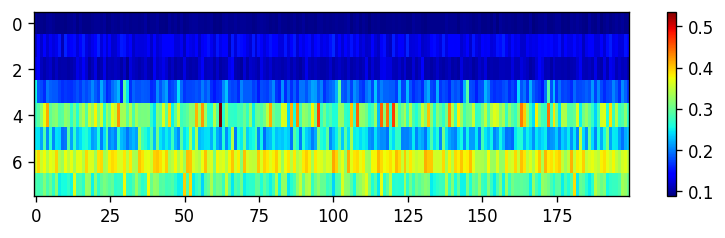

In [4]:

sobj = hhtools.SummaryLoader("./data", read_cache=False)
print(sobj.controls)
print(sobj.summary["chi"].shape)

plt.figure(figsize=(8, 2))
plt.imshow(sobj.summary['chi'][:,:,0], aspect="auto", cmap="jet", interpolation="none")
plt.colorbar()
plt.show()

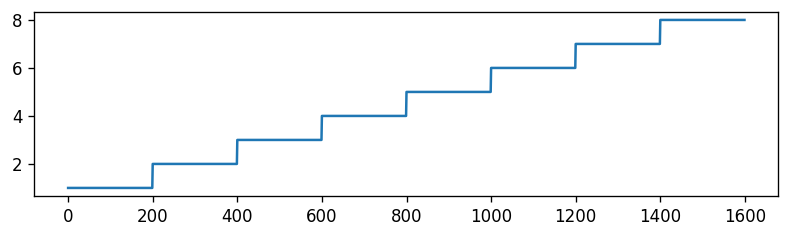

In [5]:
with open("./data/selected_points.txt", "r") as fp:
    line = fp.readline()
    line = fp.readline()
    
    cid_use = []
    loc_use = []
    # rank_use = []
    while line:
        cid, *vals = map(int, line[:-2].split(","))
        cid_use.append(cid)
        loc_use.append(vals)
        # rank_use.append(vals[2])
        line = fp.readline()

plt.figure(dpi=120, figsize=(8, 2))
plt.plot(cid_use)    
plt.show()

## Spectral Property

In [6]:
def _fft(detail):
    idt = detail["ts"] >= 0.5
    vlfp = detail["vlfp"][nt][idt]
    ts = detail["ts"][idt]
    fs = np.round(1/(ts[1] - ts[0]))

    # psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, ts, fs, mbin_t=0.1, wbin_t=1, frange=(3, 120))
    psd, fpsd = hhsignal.get_fft(vlfp, fs, nbin_t=2, frange=(3, 200))
    return psd, fpsd


np.random.seed(100)

sobj_base = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data")

psd_set = []
psd_base_set = []

nsample = 20
for cid in range(1, 9):

    psd_tot = [0, 0, 0]
    for ni in np.random.choice(sobj.num_controls[1], nsample, replace=False):
        detail = sobj.load_detail(cid-1, ni)
    
        for nt in range(3):    
            psd, fpsd = _fft(detail)
            psd_tot[nt] += psd/nsample
    
    psd_set.append(psd_tot)
    
    # base
    psd_base = [0, 0, 0]    
    rank_set = np.array([l[2] for l in loc_use])[np.array(cid_use) == cid]
    
    for ni in range(5):
        detail_base = sobj_base.load_detail(0, 0, np.round(np.average(rank_set)), 0, ni)
        for nt in range(3):
            psd_b, fpsd_b = _fft(detail_base)
            psd_base[nt] += psd_b/5
    
    psd_base_set.append(psd_base)


Load cache file


## Total population

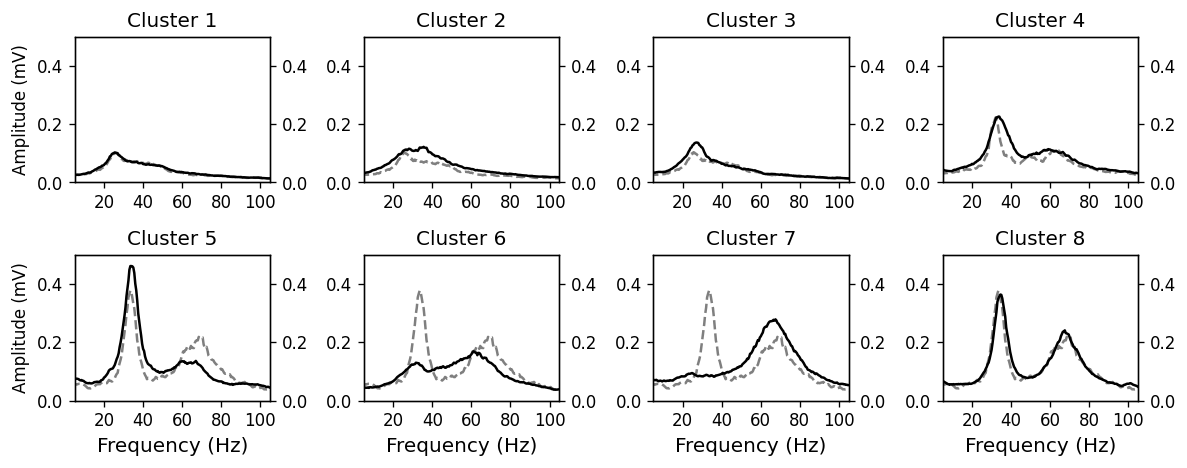

In [323]:
from scipy.signal import savgol_filter

cset = ["k", "#b50202", "#008bdd"]
name = ["tot", "fast", "slow"]

plt.figure(dpi=120, figsize=(10, 4))
for nc in range(8):
    plt.subplot(2,4,nc+1)
    
    yhat = savgol_filter(psd_set[nc][0], 9, 1)
    plt.plot(fpsd, yhat, c=cset[0], label=name[0])
        
    plt.title("Cluster %d"%(nc+1))
    plt.xticks(np.arange(0, 120, 20))
    plt.ylim([0, 0.5])
        
    if nc % 4 == 0:
        plt.ylabel("Amplitude (mV)", fontsize=10)
    
    if nc > 3:
        plt.xlabel("Frequency (Hz)", fontsize=12)
    
    plt.twinx()
    yhat = savgol_filter(psd_base_set[nc][0], 9, 1)
    plt.plot(fpsd_b, yhat, c=cset[0], alpha=0.5, linestyle='--')
    
    plt.xlim([5, 105])
    plt.ylim([0, 0.5])
    
plt.tight_layout()
plt.show()

## Subpopulation

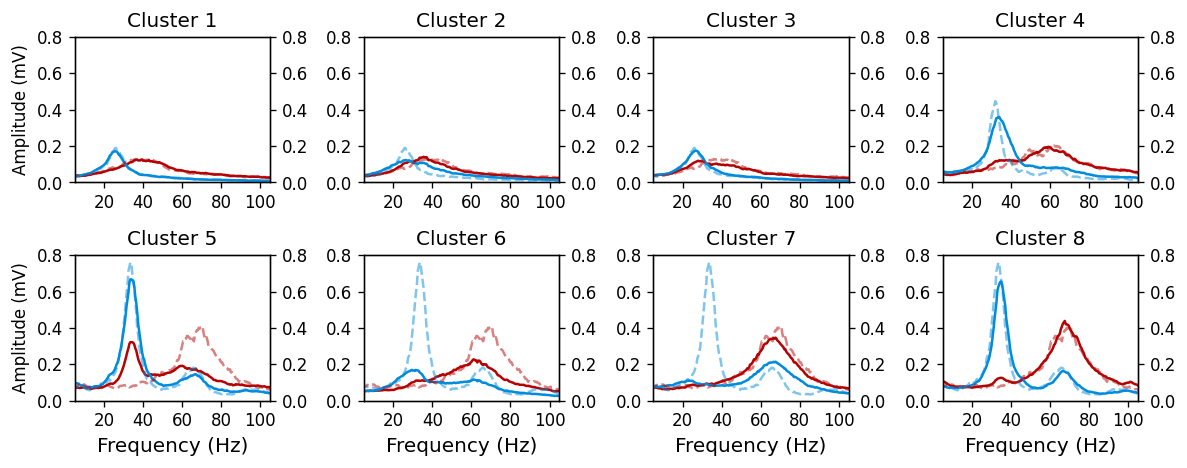

In [324]:


cset = ["k", "#b50202", "#008bdd"]
name = ["tot", "fast", "slow"]

plt.figure(dpi=120, figsize=(10, 4))
for nc in range(8):
    plt.subplot(2,4,nc+1)
    
    for nt in range(1, 3):
        # y = psd_set[nc][nt]
        yhat = savgol_filter(psd_set[nc][nt], 9, 1)
        # plt.plot(fpsd, y, c=cset[nt], alpha=0.2)
        plt.plot(fpsd, yhat, c=cset[nt], label=name[nt])
        
    # plt.xlim([5, 105])
    plt.title("Cluster %d"%(nc+1))
    plt.xticks(np.arange(0, 120, 20))
    plt.ylim([0, 0.8])
    
    # if nc == 0:
    #     plt.legend(loc="upper right", fontsize=10)
        
    if nc % 4 == 0:
        plt.ylabel("Amplitude (mV)", fontsize=10)
    
    if nc > 3:
        plt.xlabel("Frequency (Hz)", fontsize=12)
    
    plt.twinx()
    for nt in range(1, 3):
        yhat = savgol_filter(psd_base_set[nc][nt], 9, 1)
        plt.plot(fpsd_b, yhat, c=cset[nt], alpha=0.5, linestyle='--')
    
    plt.xlim([5, 105])
    plt.ylim([0, 0.8])
    
    # plt.ylim([0, 0.8])
    
plt.tight_layout()
plt.show()

## Draw frequency peak (total)

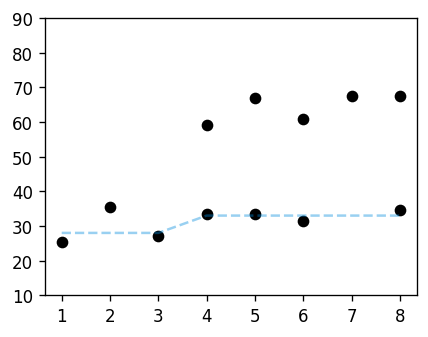

In [326]:
plt.figure()

cset = ["k", "#b50202", "#008bdd"]
markers = ["o", "o", "x"]

fpeaks_b = [[], [], []]

nt = 0
for nc in range(8):

    # for nt in range(1, 3):
    yhat = savgol_filter(psd_set[nc][nt], 9, 1)
    npeaks = hhsignal.detect_peak(yhat, prominence=0.015, mode=0)

    for n in npeaks:
        plt.plot(nc+1, fpsd[n], markers[nt], color=cset[nt])
        
    yhat_b = savgol_filter(psd_base_set[nc][nt], 21, 1)
    npeaks = hhsignal.detect_peak(yhat_b, prominence=0.04, mode=0)
    
    fpeaks_b[nt].append(fpsd[npeaks[0]])
    
    # if nt == 1:
    #     plt.figure()
    #     plt.plot(yhat_b)
    
        # # for n in npeaks:
        # n = npeaks[0]
        # plt.plot(nc+1, fpsd[n], markers[nt], color=cset[nt], alpha=0.1)

# plt.plot(np.arange(8)+1, fpeaks_b[1], '--', c=cset[1], alpha=0.4)
plt.plot(np.arange(8)+1, fpeaks_b[0], '--', c=cset[2], alpha=0.4)

plt.xticks(np.arange(1, 9))
plt.ylim([10, 90])
plt.show()

## Frequency peak (subpopulation)

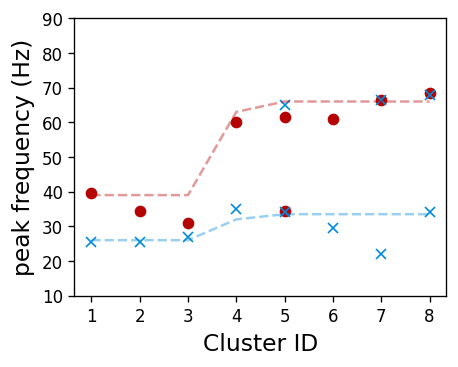

In [13]:
plt.figure()

cset = ["k", "#b50202", "#008bdd"]
markers = ["", "o", "x"]

fpeaks_b = [[], [], []]

for nc in range(8):
    for nt in range(1, 3):
        yhat = savgol_filter(psd_set[nc][nt], 21, 1)
        npeaks = hhsignal.detect_peak(yhat, prominence=0.015, mode=0)
        
        # print("Cluster %d"%(nc+1))
        for n in npeaks:
            plt.plot(nc+1, fpsd[n], markers[nt], color=cset[nt])
            # print("%.3f"%(fpsd[n]))
            
        yhat_b = savgol_filter(psd_base_set[nc][nt], 21, 1)
        npeaks = hhsignal.detect_peak(yhat_b, prominence=0.04, mode=0)
        
        fpeaks_b[nt].append(fpsd[npeaks[0]])

plt.plot(np.arange(8)+1, fpeaks_b[1], '--', c=cset[1], alpha=0.4)
plt.plot(np.arange(8)+1, fpeaks_b[2], '--', c=cset[2], alpha=0.4)

plt.xticks(np.arange(1, 9))
plt.ylim([10, 90])

plt.xlabel("Cluster ID", fontsize=14)
plt.ylabel("peak frequency (Hz)", fontsize=14)

plt.show()

## Sync

In [328]:
import xarray as xa

postdata = xa.load_dataarray("../three_pop_mpi/simulation_data/postdata.nc")
print(postdata.key)

<xarray.DataArray 'key' (key: 16)>
array(['chi', 'cv', 'frs_m', 'ac2p_large', 'tlag_large', 'ac2p_1st',
       'tlag_1st', 'pwr_large_ft', 'tlag_large_ft', 'pwr_1st_ft',
       'tlag_1st_ft', 'cc1p', 'tlag_cc', 'leading_ratio', 'leading_ratio(abs)',
       'dphi'], dtype=object)
Coordinates:
  * key      (key) object 'chi' 'cv' 'frs_m' ... 'leading_ratio(abs)' 'dphi'


In [329]:
sync_sub_all = []
sync_base_all = []
for nc in range(8):
    sync_sub = []
    sync_base = []
    for l in loc_use[nc*200:(nc+1)*200]:
        chi = postdata.isel(alpha=l[0], beta=l[1], rank=l[2], w=l[3]).sel(key="chi", type="var")
        sync_sub.append(chi.data)
        
        chi = postdata.isel(alpha=0, beta=0, rank=l[2], w=l[3]).sel(key="chi", type="var")
        sync_base.append(chi.data)
        
    sync_sub_all.append(np.average(sync_sub, axis=0))
    sync_base_all.append(np.average(sync_base, axis=0))
    
sync_sub_all = np.array(sync_sub_all)        
sync_base_all = np.array(sync_base_all)

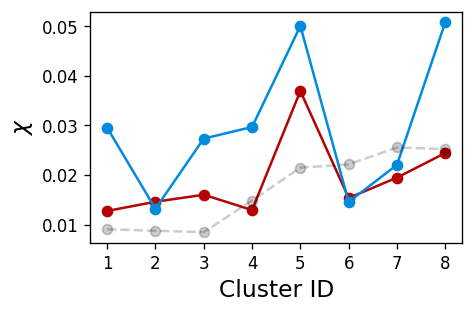

In [330]:
x = np.arange(1, 9)

plt.figure(dpi=120, figsize=(4, 2.5))
for nt in range(1, 3):
    plt.plot(x, sync_sub_all[:, nt], 'o-', c=cset[nt])
plt.plot(x, sync_base_all[:, 1], 'o--', c='k', alpha=0.2)
plt.xticks(np.arange(1, 9))
plt.ylabel(r"$\chi$", fontsize=14)
plt.xlabel("Cluster ID", fontsize=14)
plt.show()

In [331]:
fs = int(2000)
tmax = 10.5
teq  = 0.5
wbin_t = 0.5
mbin_t = 0.01
max_lag = 0.05
frange = (2/wbin_t, 100)

cid = 8
nitr = 120

detail = sobj.load_detail(cid-1, nitr)
idt = detail["ts"] >= teq
t = detail["ts"][idt]
vs = [v[idt] for v in detail["vlfp"]]

psd_set = []
for nt in range(3):
    psd, fpsd, tpsd = hhsignal.get_stfft(vs[nt], t, fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=frange)
    psd_set.append(psd)

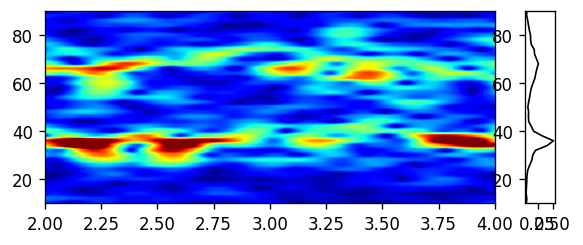

In [332]:
plt.figure(dpi=120, figsize=(5, 2))
plt.axes(position=[0.1, 0.1, 0.75, 0.8])
hhtools.imshow_xy(psd_set[0], x=tpsd, y=fpsd, cmap="jet", vmax=0.6, vmin=0)
plt.xlim([2, 4])
# plt.colorbar()
plt.ylim([10, 90])

plt.axes(position=(0.9, 0.1, 0.05, 0.8))
plt.plot(np.average(psd_set[0], axis=1), fpsd, c='k', lw=1)
plt.ylim([10, 90])

plt.show()

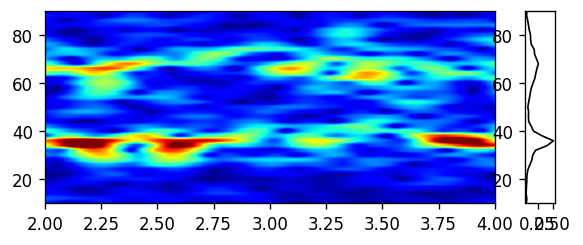

In [333]:
plt.figure(dpi=120, figsize=(5, 2))
plt.axes(position=[0.1, 0.1, 0.75, 0.8])
hhtools.imshow_xy(psd_set[0], x=tpsd, y=fpsd, cmap="jet", vmax=None, vmin=0)
plt.xlim([2, 4])
# plt.colorbar()
plt.ylim([10, 90])

plt.axes(position=(0.9, 0.1, 0.05, 0.8))
plt.plot(np.average(psd_set[0], axis=1), fpsd, c='k', lw=1)
plt.ylim([10, 90])

plt.show()

# Amplitude correlation

In [ ]:
tmax = 10.5
teq = 0.5
wbin_t = 0.2
mbin_t = 0.01
fs = 2000

detail = sobj.load_detail(1, 100)
vsub = detail["vlfp"]

t0_set =  np.arange(teq, tmax-wbin_t, mbin_t)
f12_mat = np.zeros([len(f), len(t0_set)])
for n, t0 in enumerate(t0_set):
    n0 = int(t0 * fs)
    
    vsub = [v[n0:n0+int(fs*wbin_t)] for v in detail["vlfp"]]
    v1 = vsub[1] - np.average(vsub[1])
    v2 = vsub[2] - np.average(vsub[2])
    
    v12, tlag = hhsignal.get_correlation(v1, v2, 2000, max_lag=wbin_t/2)
    f12_mat[:, n], f = hhsignal.get_fft(v12, 2000, frange=frange)
    
    


    # n0 = int((np.random.rand() * (tmax - teq - wbin_t) + teq) * fs)


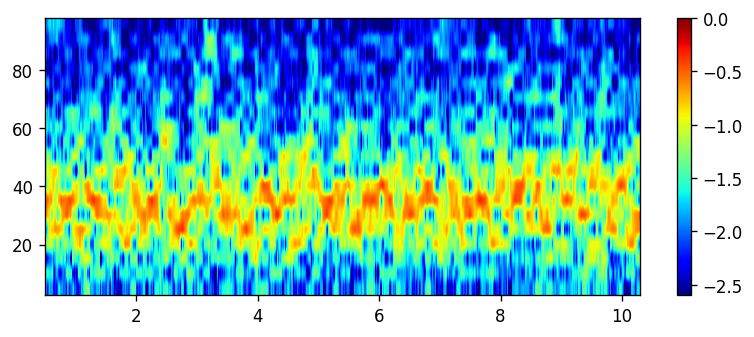

In [ ]:
plt.figure(figsize=(8, 3))
hhtools.imshow_xy(np.log10(f12_mat), x=t0_set, y=f, cmap="jet", vmin=-2.6, vmax=0)
plt.colorbar()
plt.show()

In [ ]:
frange = (2, 100)

v1 = vsub[1] - np.average(vsub[1])
v2 = vsub[2] - np.average(vsub[2])

v12, tlag = hhsignal.get_correlation(v1, v2, 2000, max_lag=wbin_t/2)
f12, f = hhsignal.get_fft(v12, 2000, frange=frange)

fx, f = hhsignal.get_fft(v1, 2000, frange=frange)
fy, f = hhsignal.get_fft(v2, 2000, frange=frange)


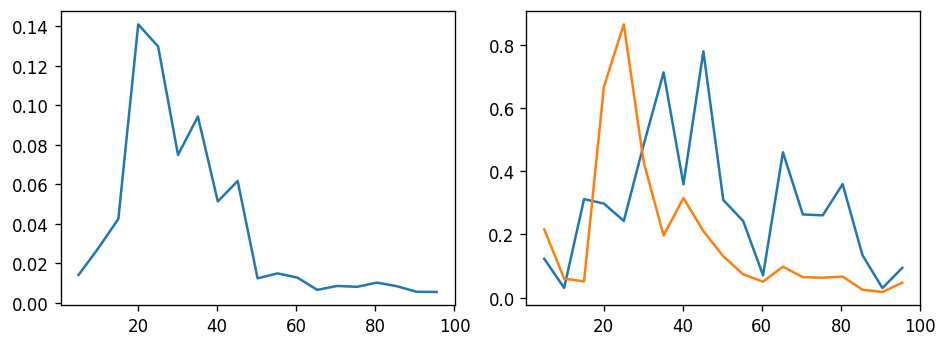

In [ ]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(f, f12)
plt.subplot(122)
plt.plot(f, fx)
plt.plot(f, fy)
plt.tight_layout()

In [ ]:
detail = sobj.load_detail(6, 100)

ts = detail["ts"]
vlfp = detail["vlfp"][1]

(-65.0, -55.0)

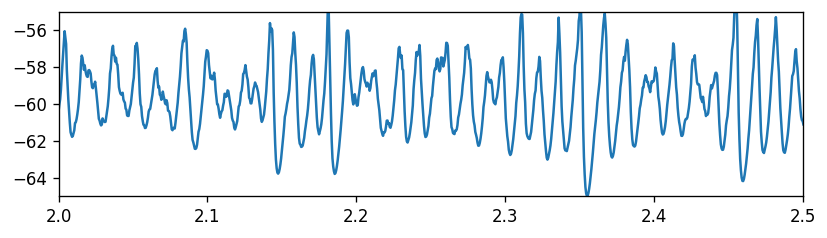

In [ ]:
plt.figure(figsize=(8, 2))
plt.plot(ts, vlfp)
plt.xlim([2, 2.5])
plt.ylim([-65, -55])

In [ ]:
from scipy import signal

def filt(sig, f1, f2, fs=2000, fo=10):
    sos1 = signal.butter(fo, f1, 'hp', fs=fs, output='sos')
    # sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')
    filtered = signal.sosfilt(sos1, sig)
    
    sos2 = signal.butter(fo, f2, 'lp', fs=fs, output='sos')
    filtered = signal.sosfilt(sos2, filtered)
    
    return filtered

In [438]:
cid = 2

frange = [[25, 35], [70, 80]]

# phs_set, amp_set = [[], []], [[], []]
phs_set = [[[], []] for _ in range(len(frange))]
amp_set = [[[], []] for _ in range(len(frange))]

for i in range(80):
    detail = sobj.load_detail(cid-1, i)
    for nt in range(2):
        v = detail["vlfp"][nt+1]
        
        for nf in range(2):
            yfilt = filt(v, frange[nf][0], frange[nf][1], fs=2000, fo=10)
        
            yf = signal.hilbert(yfilt)
            yabs = np.abs(yf)
            yphs = np.angle(yf)
            
            for ns in detail["step_spk"][nt*1000:(nt+1)*1000]:
                _ns = (np.array(ns) * 0.01 / 1000 * 2000).astype(int)
                phs_set[nf][nt].extend(yphs[_ns])
                amp_set[nf][nt].extend(yabs[_ns])


for i in range(2):
    for j in range(2):
        phs_set[i][j] = np.array(phs_set[i][j])
        amp_set[i][j] = np.array(amp_set[i][j])



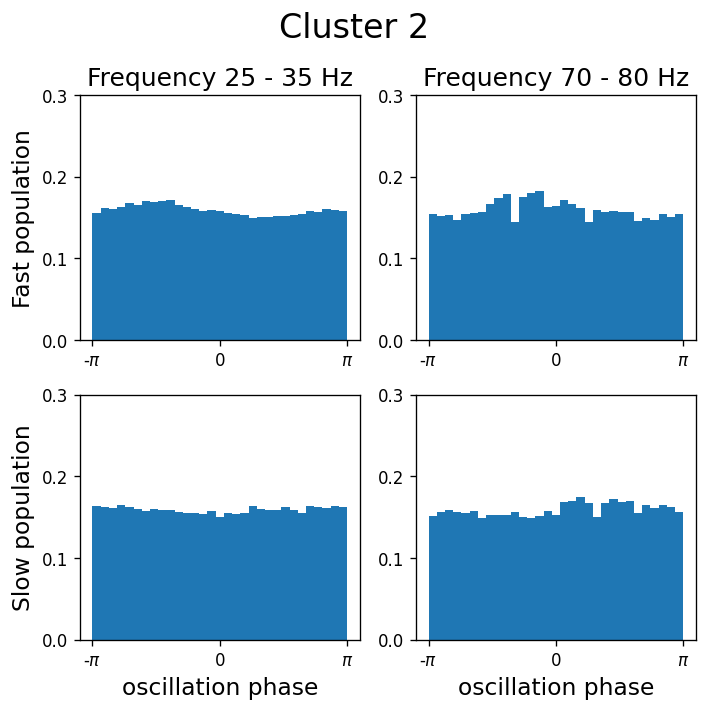

In [440]:
tp_names = ["Fast", "Slow"]

plt.figure(dpi=120, figsize=(6, 6))
for nt in range(2):
    for nf in range(2):
        plt.subplot(2,2,nt*2+nf+1)
        amp = amp_set[nf][nt]
        amax = np.percentile(amp, 95)
        plt.hist(phs_set[nf][nt][amp > amax], 31, density=True)
        
        plt.xticks(np.arange(-np.pi, np.pi+0.1, np.pi),
                   labels=(r"-$\pi$", "0", "$\pi$"))
        plt.yticks(np.arange(0, 0.4, 0.1))
        
        if nt == 0:
            plt.title("Frequency %d - %d Hz"%(frange[nf][0], frange[nf][1]),
                      fontsize=15)
        else:
            plt.xlabel("oscillation phase", fontsize=14)
        
        if nf == 0:
            plt.ylabel("%s population"%(tp_names[nt]), fontsize=14)
        
        
plt.suptitle("Cluster %d"%(cid), fontsize=20)
plt.tight_layout()
plt.show()

In [399]:
range(-2, 2.1, 1)

TypeError: 'float' object cannot be interpreted as an integer

(array([441317., 439474., 449297., 447356., 435047., 417343., 409560.,
        421212., 424172., 432001.]),
 array([-3.14156858, -2.51325316, -1.88493773, -1.2566223 , -0.62830688,
         0.00000855,  0.62832398,  1.2566394 ,  1.88495483,  2.51327025,
         3.14158568]),
 <BarContainer object of 10 artists>)

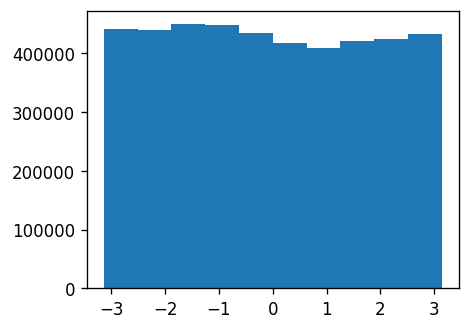

In [387]:
plt.hist(phs_set[0][0])

In [383]:
amax_th = np.percentile(amp_set[1], 90)
amin_th = np.percentile(amp_set[1], 10)
print(amax_th, amin_th)

4.187952133278169 0.6096719305685301


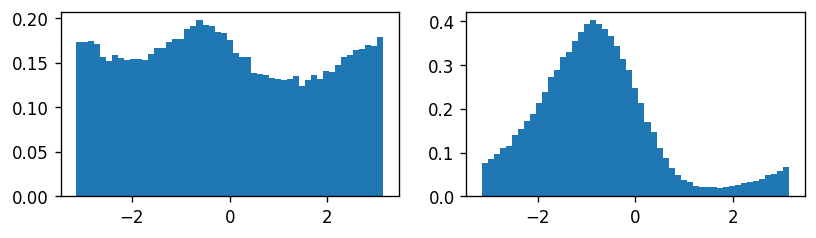

In [384]:
plt.figure(figsize=(8, 2))

for nt in range(2):
    # for i in range(2):
    amax_th = np.percentile(amp_set[nt], 90)
    plt.subplot(1,2,nt + 1)
    plt.hist(phs_set[nt][amp_set[nt] > amax_th], 51, density=True)
# plt.subplot(212)
# plt.hist(phs_set[1][amp_set[1] < amin_th], 51, density=True)
plt.show()

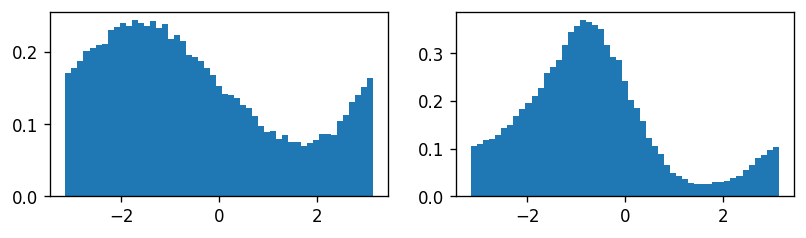

In [381]:
plt.figure(figsize=(8, 2))

for nt in range(2):
    # for i in range(2):
    amax_th = np.percentile(amp_set[nt], 90)
    plt.subplot(1,2,nt + 1)
    plt.hist(phs_set[nt][amp_set[nt] > amax_th], 51, density=True)
# plt.subplot(212)
# plt.hist(phs_set[1][amp_set[1] < amin_th], 51, density=True)
plt.show()

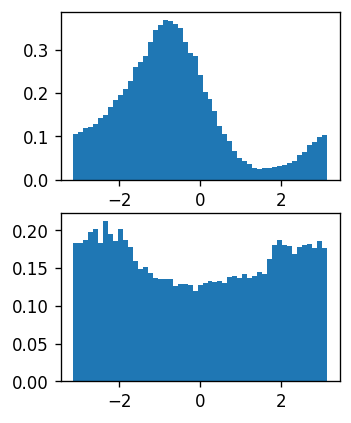

In [377]:
plt.figure(figsize=(3, 4))

plt.subplot(211)
plt.hist(phs_set[1][amp_set[1] > amax_th], 51, density=True)
plt.subplot(212)
plt.hist(phs_set[1][amp_set[1] < amin_th], 51, density=True)
plt.show()

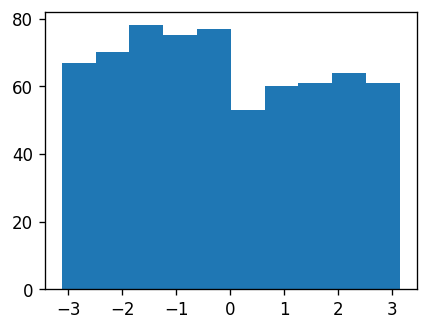

In [ ]:
plt.figure()
plt.hist(phs_set[amp_set > 0.5])
plt.show()

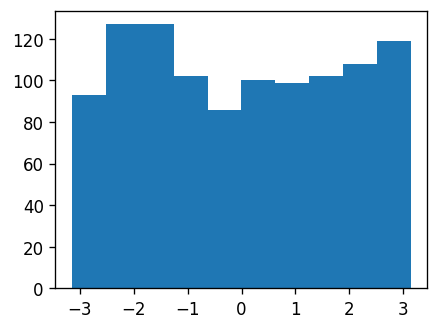

In [ ]:
plt.figure()
plt.hist(phs_set[amp_set < 0.5])
plt.show()

In [ ]:
detail = sobj.load_detail(6, 100)
# yfilt = filt(vlfp, 70, 80, fs=2000, fo=10)
yfilt = filt(vlfp, 30, 40, fs=2000, fo=10)

yf = signal.hilbert(yfilt)
yabs = np.abs(yf)
yphs = np.angle(yf)

amp_set = []
phs_set = []
for nt in detail["step_spk"]:
    
    _nt = (np.array(nt) * 0.01 / 1000 * 2000).astype(int)
    phs_set.extend(yphs[_nt])
    amp_set.extend(yabs[_nt])
    
amp_set = np.array(amp_set)
phs_set = np.array(phs_set)

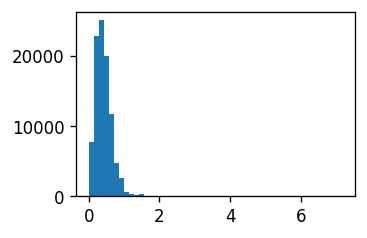

In [ ]:
plt.figure(figsize=(3, 2))
plt.hist(amp_set, 51)
plt.show()

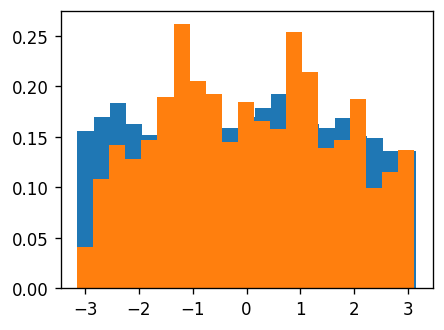

In [ ]:
plt.figure()
plt.hist(phs_set[amp_set < 0.5], 21, density=True)
plt.hist(phs_set[amp_set > 1], 21, density=True)
plt.show()

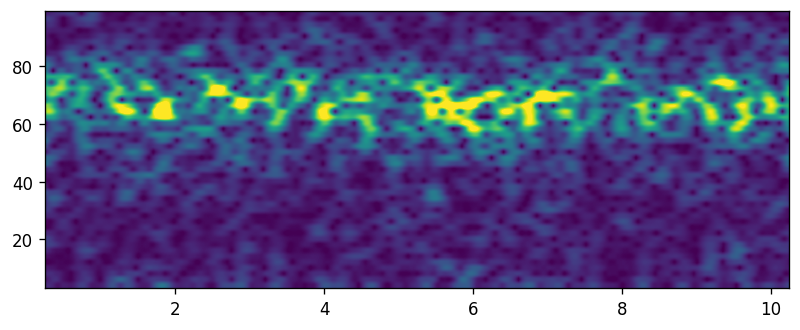

In [ ]:
plt.figure(figsize=(8, 3))
hhtools.imshow_xy(psd, y=fpsd, x=tpsd)

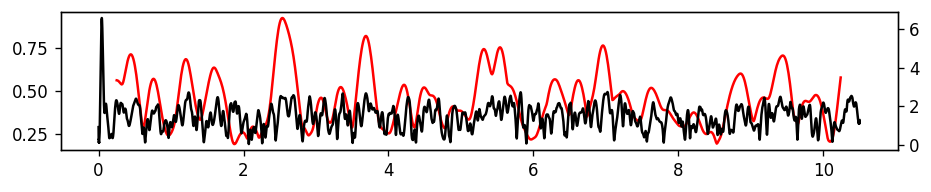

In [ ]:
from scipy.signal import hilbert

plt.figure(figsize=(9, 1.5))
plt.plot(tpsd, ypsd, 'r')

plt.twinx()
yabs = np.abs(hilbert(yfilt))

plt.plot(detail["ts"], yabs, 'k')
plt.show()

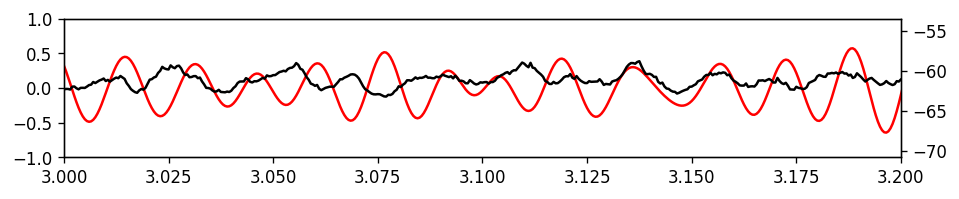

In [ ]:
plt.figure(figsize=(9, 1.5))
plt.plot(ts, y, c='r')
plt.ylim([-1, 1])
plt.xlim([3, 3.2])

plt.twinx()
plt.plot(ts, vlfp, c='k')

plt.show()

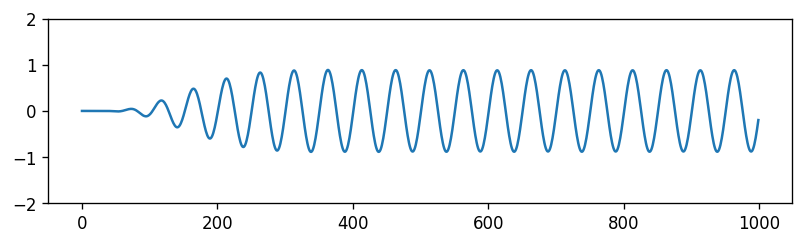

In [ ]:
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
filtered = filt(sig, 18, 22, fo=10, fs=1000)

plt.figure(figsize=(8, 2))
plt.plot(filtered)
plt.ylim([-2, 2])
plt.show()

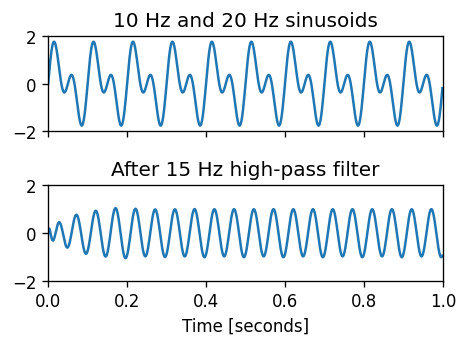

In [ ]:
from scipy import signal

t = np.linspace(0, 1, 1000, False)  # 1 second

sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t, sig)

ax1.set_title('10 Hz and 20 Hz sinusoids')

ax1.axis([0, 1, -2, 2])

sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, sig)

ax2.plot(t, filtered)

ax2.set_title('After 15 Hz high-pass filter')

ax2.axis([0, 1, -2, 2])

ax2.set_xlabel('Time [seconds]')

plt.tight_layout()

plt.show()

In [ ]:
with open("./corr_cid%d.pkl", "rb") as fp:
    data = pkl.load(fp)

In [ ]:
data["corr_mat"].keys()

dict_keys(['z(t)-z(t)', 'z(f)-z(f)', 'z(f)-z(s)', 'z(s)-z(s)', 'z(t)-v(t)', 'z(f)-v(f)', 'z(f)-v(s)', 'z(s)-v(s)', 'v(t)-v(t)', 'v(f)-v(f)', 'v(f)-v(s)', 'v(s)-v(s)'])

In [ ]:
np.max(data["corr_mat"]['z(f)-z(f)'][0])

2.2071418275528822

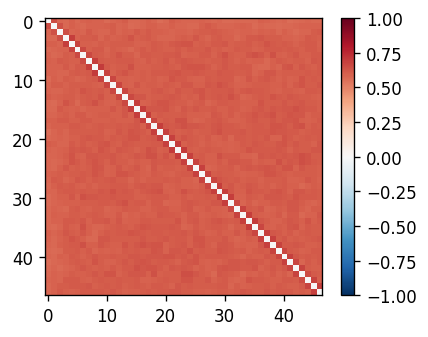

In [ ]:
vm = 1
plt.imshow(data["corr_mat"]['v(f)-v(f)'][1], vmax=vm, vmin=-vm, cmap="RdBu_r")
plt.colorbar()

In [ ]:
plt.imshow(data["corr_mat"][0]['z(f)-z(f)'][2], vmax=0.2)
plt.colorbar()

TypeError: list indices must be integers or slices, not str

In [ ]:
tmp = defaultdict(lambda: np.zeros([4,4]))

with open("./dump.pkl", "wb") as fp:
    pkl.dump(tmp, fp)

PicklingError: Can't pickle <function <lambda> at 0x7f074bb1e170>: attribute lookup <lambda> on __main__ failed

In [ ]:
tmp[0]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
dict(tmp)

{0: array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])}

In [ ]:
tmp

defaultdict(<function __main__.<lambda>()>,
            {0: array([[0., 0., 0., 0.],
                    [0., 0., 0., 0.],
                    [0., 0., 0., 0.],
                    [0., 0., 0., 0.]])})

In [ ]:
from tqdm.notebook import trange

fs = int(2000)
tmax = 10.5
teq  = 0.5
wbin_t = 0.5
mbin_t = 0.01
max_lag = 0.05
frange = (2/wbin_t, 100)

nitr_max = 200

# corr_maps = []
len_f = int((frange[1] - frange[0]) * wbin_t)
corr_maps = np.zeros([8, 4, len_f, len_f])

for cid in trange(1, 9):
    # corr_map_f = [0, 0, 0]
    for nitr in range(nitr_max):

        detail = sobj.load_detail(cid-1, nitr)
        idt = detail["ts"] >= teq
        t = detail["ts"][idt]
        vs = [v[idt] for v in detail["vlfp"]]

        psd_sets = []

        psd_set = []
        for nt in range(3):
            psd, fpsd, tpsd = hhsignal.get_stfft(vs[nt], t, fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=frange)
            for nf1 in range(len(fpsd)):
                y1 = psd[nf1] - np.average(psd[nf1])
                for nf2 in range(nf1, len(fpsd)):
                    y2 = psd[nf2] - np.average(psd[nf2])
                    corr_maps[cid-1][nt][nf1][nf2] += np.sum(y1 * y2) / np.std(psd[nf1]) / np.std(psd[nf2]) / len(y1) / nitr_max
                    
            if nt > 0:
                psd_sets.append(psd)    
        
        for nf1 in range(len(fpsd)):
            y1 = psd_sets[0][nf1] - np.average(psd_sets[0][nf1])
            for nf2 in range(len(fpsd)):
                y2 = psd_sets[1][nf2] - np.average(psd_sets[1][nf2])
                corr_maps[cid-1][3][nf1][nf2] += np.sum(y1 * y2) / np.std(psd[nf1]) / np.std(psd[nf2]) / len(y1) / nitr_max
    # corr_maps.append(corr_map_f)

  0%|          | 0/8 [00:00<?, ?it/s]

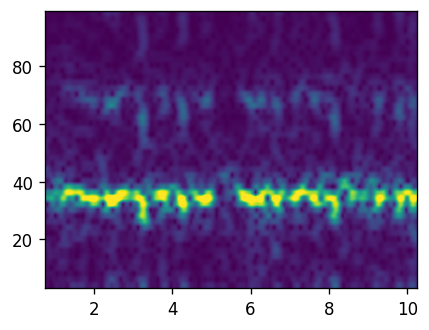

In [ ]:
hhtools.imshow_xy(psd, x=tpsd, y=fpsd)

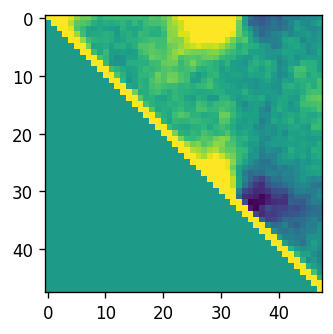

In [ ]:
plt.imshow(corr_maps[6][2], vmax=0.1)

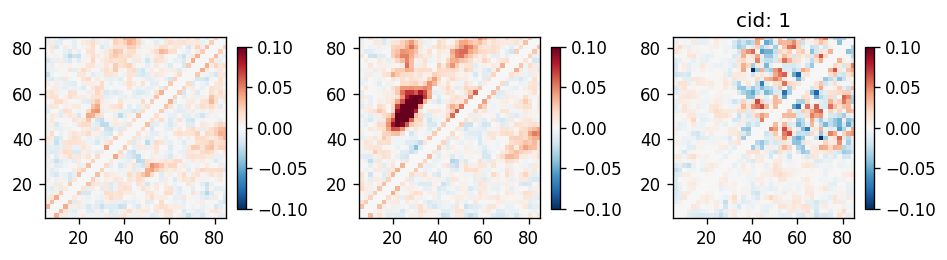

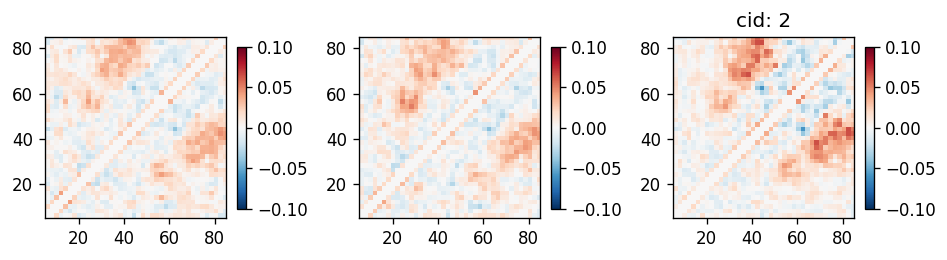

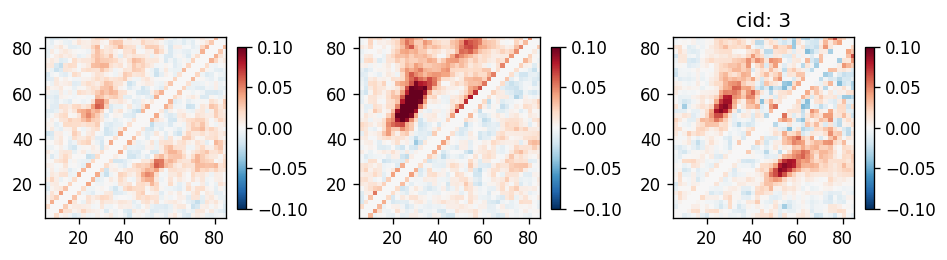

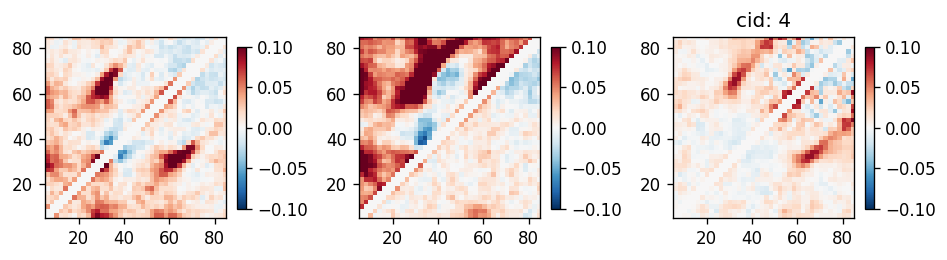

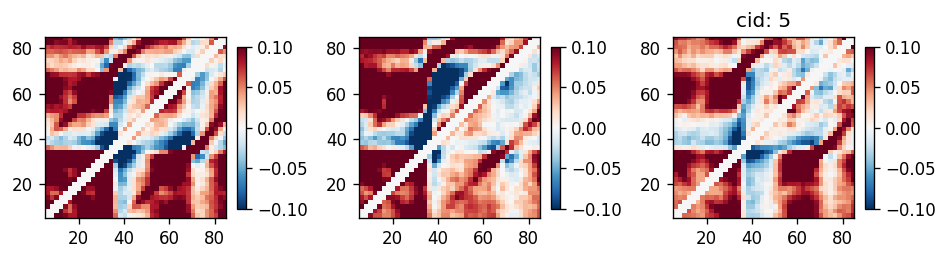

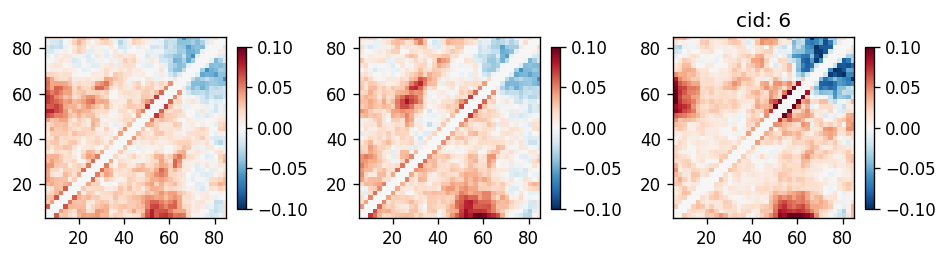

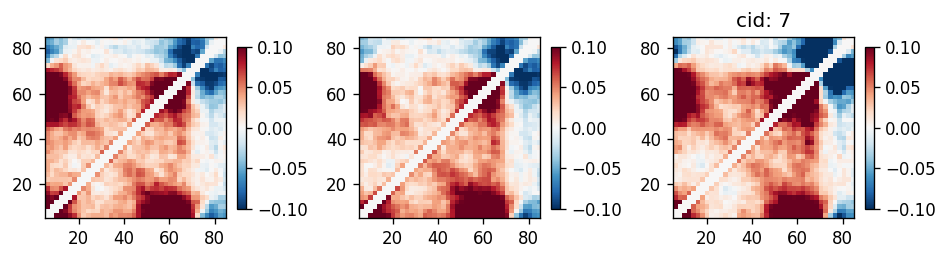

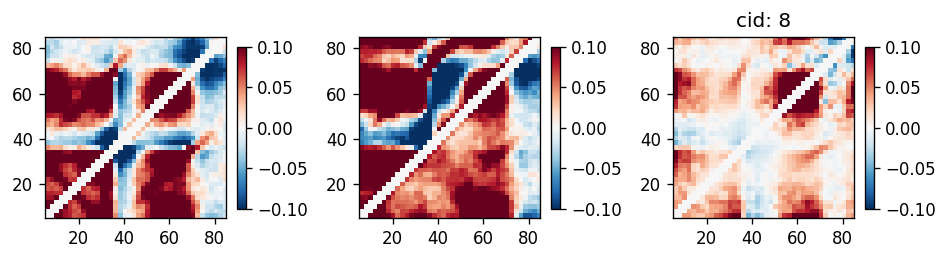

In [ ]:
# im = corr_maps[1][2].copy()
# for i in range(im.shape[0]):
#     im[i, i] = 0

for cid in range(1, 9):

    plt.figure(figsize=(8, 3))
    
    for nt in range(3):
        
        if nt == 0 or nt == 2:
            if nt == 0:
                im = corr_maps[cid-1][0].copy() 
            else:
                im = corr_maps[cid-1][3].copy() 

            for i in range(len_f):
                for j in range(i+1, len_f):
                    im[j, i] = im[i, j]
        elif nt == 1:
            im = corr_maps[cid-1][1].copy()
            for i in range(len_f):
                for j in range(i+1, len_f):
                    im[j, i] = corr_maps[cid-1][2][i, j]
        
        for i in range(im.shape[0]):
            im[i, i] = 0
            if i > 1:
                im[i-1, i] = 0
                im[i, i-1] = 0
                
        plt.subplot(1,3,nt+1)
        
        # vm = np.round(np.percentile(im, 99), 1)
        vm = 0.1
        hhtools.imshow_xy(im, x=fpsd, y=fpsd, cmap="RdBu_r", vmin=-vm, vmax=vm, interpolation="nearest")
        plt.colorbar(shrink=0.5)
        plt.axis("square")
        plt.xticks(np.arange(20, 100, 20))
        plt.yticks(np.arange(20, 100, 20))
        plt.ylim([5, 85])
        plt.xlim([5, 85])
        
    plt.tight_layout()
    plt.title("cid: %d"%(cid))
    plt.show()

48

In [ ]:
fs = int(2000)
tmax = 10.5
teq  = 0.5
wbin_t = 0.5
mbin_t = 0.01
max_lag = 0.05
frange = (2/wbin_t, 100)

cc_max_avg = np.zeros([8, 3, len_f, len_f])
tlag_max_avg = np.zeros([8, 3, len_f, len_f])

for cid in range(1, 9):
    for nitr in trange(nitr_max):
        detail = sobj.load_detail(cid-1, nitr)
        idt = detail["ts"] >= teq
        t = detail["ts"][idt]
        vs = [v[idt] for v in detail["vlfp"]]
        
        psd1, fpsd, tpsd = hhsignal.get_stfft(vs[1], t, fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=frange)
        psd2, _, _       = hhsignal.get_stfft(vs[2], t, fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=frange)
        
        for nt in range(3):
            if nt == 0:
                p1, p2 = psd1, psd1
            elif nt == 1:
                p1, p2 = psd2, psd2
            else:
                p1, p2 = psd1, psd2
            
            for nf1 in range(len(fpsd)):
                y1 = p1[nf1] - np.average(p1[nf1])
                for nf2 in range(nf1+1, len(fpsd)):
                    y2 = p2[nf2] - np.average(p2[nf2])                    
                    
                    cc, tlag = hhsignal.get_correlation(y1, y2, srate=2000, max_lag=0.05)
                    try:
                        npeaks = hhsignal.detect_peak(cc, prominence=0.01, mode=0)
                
                        npeaks_max = npeaks[np.argmax(cc[npeaks])]
                        cc_max = cc[npeaks_max]
                        tlag_max = tlag[npeaks_max]
                    except:
                        cc_max, tlag_max = 0, 0
                    
                    cc_max_avg[cid-1, nt, nf1, nf2] += cc_max/nitr_max
                    tlag_max_avg[cid-1, nt, nf1, nf2] += tlag_max/nitr_max
                

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(3.0060120240480956, 99.19839679358716, 3.0060120240480956, 99.19839679358716)

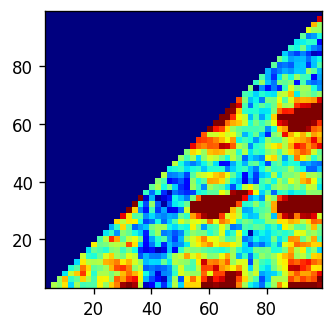

In [ ]:
hhtools.imshow_xy(cc_max_avg[7, 2], vmax=0.25, vmin=0.2, cmap="jet", x=fpsd, y=fpsd)
plt.axis("square")

## pop_rate - amplitude

In [ ]:
1/2000

0.0005

In [ ]:
def get_pop_rate(step_spk, fs=2000, tmax=10500, dt=0.01):
    l = int(tmax / 1000 * fs)
    pop_rate = np.zeros(l)
    for _nt in step_spk:
        nt = (np.array(_nt) * dt / 1000 * fs).astype(int)
        pop_rate[nt] += 1
    return pop_rate / len(step_spk) * fs, np.arange(l)/fs

In [ ]:
detail = sobj.load_detail(2, 100)
pop_rate, t = get_pop_rate(detail["step_spk"])
pop_rate = savgol_filter(pop_rate, 11, 1)


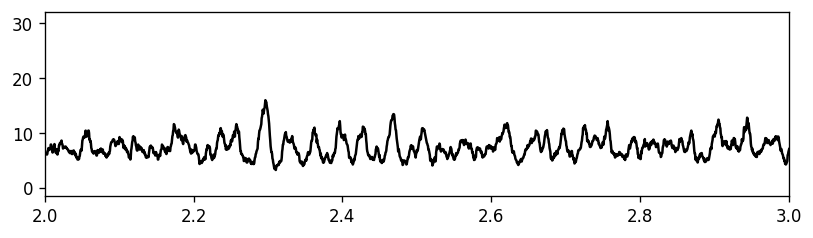

In [ ]:
plt.figure(dpi=120, figsize=(8, 2))
plt.plot(t, pop_rate, 'k')
plt.xlim([2, 3])
plt.show()

In [ ]:

im = 0
for n in range(2, 8):
    n0 = int(n * fs)

    yf, f = hhsignal.get_fft(detail["vlfp"][1][n0:n0+fs//2], fs=2000, frange=(2, 200))
    yf_pop, f = hhsignal.get_fft(pop_rate[n0:n0+fs//2], fs=2000, frange=(2, 200))
    
    y1 = (yf - np.average(yf)) / np.std(yf)
    y2 = (yf_pop - np.average(yf_pop)) / np.std(yf_pop)

    y1 = y1.reshape(-1, 1)
    y2 = y2.reshape(1, -1)
    im += y1 * y2

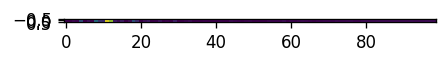

In [ ]:
plt.imshow(im)
plt.imshow(y2*y2)

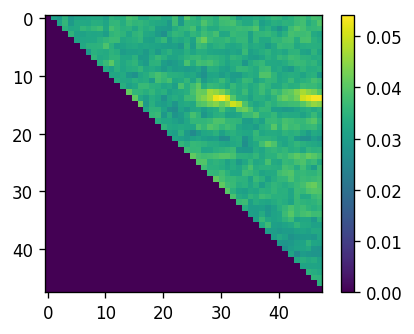

In [ ]:
plt.figure()
plt.imshow(cc_max_avg[2])
plt.colorbar()

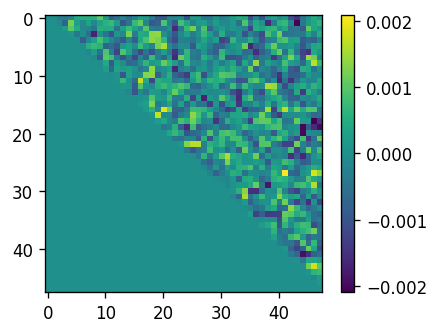

In [ ]:
plt.figure()
plt.imshow(tlag_max_avg[0])
plt.colorbar()

In [ ]:
plt.imshow(cc_max_avg)

In [ ]:
npcc[npeaks]

array([ 0.25140837,  0.20813487, -0.01091373,  0.12425917,  0.12351294,
        0.19336226, -0.03126344])

In [ ]:
from tqdm.notebook import trange

fs = int(2000)
tmax = 10.5
teq  = 0.5
wbin_t = 0.5
mbin_t = 0.01
max_lag = 0.05
frange = (2/wbin_t, 100)

nitr_max = 200

# corr_maps = []
len_f = int((frange[1] - frange[0]) * wbin_t)
corr_maps = np.zeros([8, 4, len_f, len_f])

for cid in trange(1, 9):
    # corr_map_f = [0, 0, 0]
    for nitr in range(nitr_max):

        detail = sobj.load_detail(cid-1, nitr)
        idt = detail["ts"] >= teq
        t = detail["ts"][idt]
        vs = [v[idt] for v in detail["vlfp"]]

        psd_sets = []

        psd_set = []
        for nt in range(3):
            psd, fpsd, tpsd = hhsignal.get_stfft(vs[nt], t, fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=frange)
            for nf1 in range(len(fpsd)):
                y1 = psd[nf1] - np.average(psd[nf1])
                for nf2 in range(nf1, len(fpsd)):
                    y2 = psd[nf2] - np.average(psd[nf2])                    
                    corr_maps[cid-1][nt][nf1][nf2] += np.sum(y1 * y2) / np.std(psd[nf1]) / np.std(psd[nf2]) / len(y1) / nitr_max
                    
            if nt > 0:
                psd_sets.append(psd)    
        
        for nf1 in range(len(fpsd)):
            y1 = psd_sets[0][nf1] - np.average(psd_sets[0][nf1])
            for nf2 in range(len(fpsd)):
                y2 = psd_sets[1][nf2] - np.average(psd_sets[1][nf2])
                corr_maps[cid-1][3][nf1][nf2] += np.sum(y1 * y2) / np.std(psd[nf1]) / np.std(psd[nf2]) / len(y1) / nitr_max
    # corr_maps.append(corr_map_f)

# Time dependent change of cross-correlation

In [ ]:
w_vals = np.array([-1.  , -0.9 , -0.7 , -0.5 , -0.3 , -0.1 ,  0.  ,  0.15,  0.3 ,  0.45,
        0.6 ,  0.75,  0.85,  0.9 ,  0.95,  1.  ])
w_id = [l[3] for l in loc_use]
w_use = w_vals[w_id]

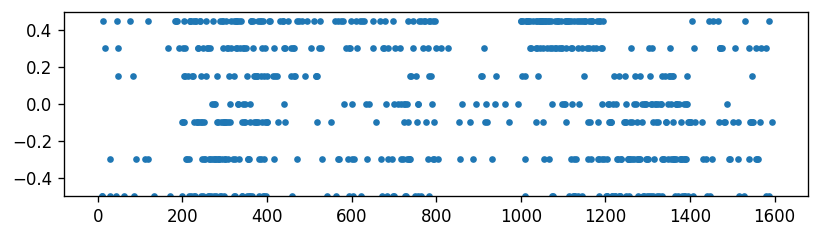

In [ ]:
plt.figure(figsize=(8, 2))
plt.plot(w_use, '.')
plt.ylim([-0.5, 0.5])
plt.show()

array([1.  , 1.  , 0.85, ..., 0.85, 0.6 , 1.  ])

In [ ]:
cid = 1
w_sub = w_use[200*(cid-1):200*cid]
print(np.min(np.abs(w_sub)))
nitr = np.argmin(np.abs(w_sub))

0.15

In [ ]:
fs = int(2000)
tmax = 10.5
teq  = 0.5
wbin_t = 0.2
mbin_t = 0.01
max_lag = 0.05
frange = (2/wbin_t, 100)

cid = 4
w_sub = w_use[200*(cid-1):200*cid]
print(np.min(np.abs(w_sub)))
nitr = np.argmin(np.abs(w_sub))

detail = sobj.load_detail(cid-1, nitr)
num_points = int((tmax - teq - wbin_t) / mbin_t)

tcc = np.arange(num_points) * mbin_t + teq

# tcc = np.arange(teq, tmax, mbin_t)
cc_mat = np.zeros([2*int(max_lag*fs)+1, num_points])
ac_mat = np.zeros([2, 2*int(max_lag*fs)+1, num_points])
psd_mat = np.zeros([2, int(wbin_t * fs)//2, num_points])

neq = int(teq*fs)
mbin = int(mbin_t*fs)
wbin = int(wbin_t*fs)

window = np.hanning(wbin)
# for n0 in range(neq, neq+num_points*mbin, mbin):
for n in range(num_points):
    n0 = n*mbin
    n1 = n0 + wbin
    
    vsub = [v[n0:n1] for v in detail["vlfp"][1:]]
    cc_mat[:, n], tlag = hhsignal.get_correlation(vsub[0], vsub[1], fs, max_lag=max_lag)
    
    for nt in range(2):
        y = vsub[nt] * window
        psd_mat[nt,:,n], fpsd = hhsignal.get_fft(y, fs)
        ac_mat[nt, :, n], _ = hhsignal.get_correlation(vsub[nt], vsub[nt], fs, max_lag=max_lag)
    # psd_mat[1,:,n], _    = hhsignal.get_fft(vsub[1], fs)

idf = (fpsd >= frange[0]) & (fpsd <= frange[1])
psd_mat = psd_mat[:,idf,:]
fpsd = fpsd[idf]

0.0


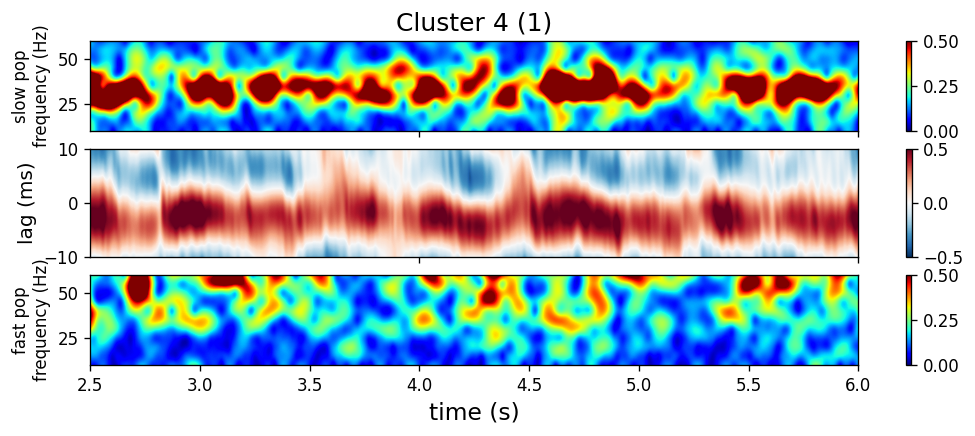

In [ ]:
def no_xlabel():
    xt, _ = plt.xticks()
    xl = plt.xlim()
    plt.xticks(xt, labels=[])
    plt.xlim(xl)
    
xl = [2.5, 6]
yl = [10, 60]
# xl = [1, 10]
vm = 0.5
vp = 0.5
pop_name = ["Fast", "Slow"]
    
plt.figure(figsize=(10, 3))

ax1 = plt.axes([0.1, 0.75, 0.8, 0.25])
hhtools.imshow_xy(psd_mat[1], x=tcc, y=fpsd, cmap="jet", vmax=vp, vmin=0, interpolation="bicubic")
plt.ylabel("slow pop\nfrequency (Hz)", fontsize=10)
no_xlabel()
plt.title("Cluster %d (%d)"%(cid, nitr), fontsize=15)
plt.colorbar()
plt.ylim(yl)

ax2 = plt.axes([0.1, 0.4, 0.8, 0.3])
hhtools.imshow_xy(cc_mat, x=tcc, y=tlag*1e3, cmap="RdBu_r", vmax=vm, vmin=-vm, interpolation="bicubic")
# +: slow pop / -: fast pop lead
no_xlabel()
plt.ylabel("lag (ms)", fontsize=12)
plt.colorbar()
plt.ylim([-10, 10])

ax3 = plt.axes([0.1, 0.1, 0.8, 0.25])
hhtools.imshow_xy(psd_mat[0], x=tcc, y=fpsd, cmap="jet", vmax=vp, vmin=0, interpolation="bicubic")
plt.ylabel("fast pop\nfrequency (Hz)", fontsize=10)

plt.xlabel("time (s)", fontsize=14)
plt.colorbar()
plt.ylim(yl)

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(xl)
    
# xt, _ = pl.

In [ ]:
def find_max2(mat):
    ind_max2 = np.zeros(mat.shape[1], int)
    for nt in range(mat.shape[1]):
        npeaks = hhsignal.detect_peak(mat[:, nt], prominence=0.05, mode=0)
        npeaks_nz = npeaks[np.abs(npeaks - mat.shape[0]//2) > 1]
        
        if len(npeaks_nz) == 0:
            continue
        
        ind_npeak_sort = np.argsort(mat[npeaks_nz, nt])[::-1]
        ind_max2[nt] = npeaks_nz[ind_npeak_sort[0]]
        
        # if nt == 10:
        #     plt.figure()
        #     plt.plot(mat[:, nt])
        #     for n in npeaks_nz:
        #         plt.plot(n, mat[n, nt], 'p')
        #     plt.plot(ind_max2[nt], mat[ind_max2[nt], nt], 'p')
        #     plt.show()
        #     raise ValueError("")
        

        # ind_sort = np.argsort(mat[npeaks, nt])[::-1]
        # if len(ind_sort) == 1:
        #     ind_max2[nt] = 0
        # else:
        #     ind_max2[nt] = npeaks[ind_sort[1]]
        
        # if abs(ind_max2[nt] - mat.shape[0]//2) < 10:
        #     plt.figure()
        #     plt.plot(mat[:, nt], 'k')
        #     for n in npeaks:
        #         plt.plot(n, mat[n, nt], 'p')
        #     # plt.plot(ind_max2[nt], mat[ind_max2[nt], nt], 'rp')
        #     plt.show()
            
        #     raise ValueError("")
            
    return ind_max2

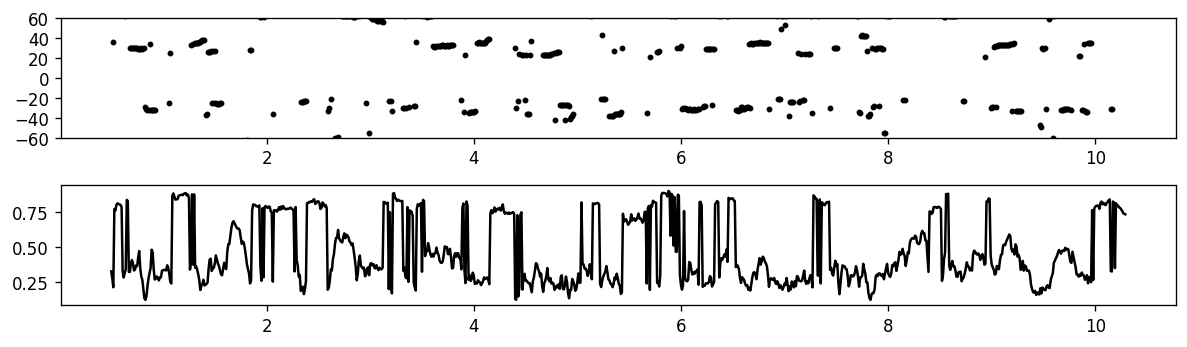

In [ ]:
ind_max2 = find_max2(cc_mat)

plt.figure(dpi=120, figsize=(10, 3))

plt.subplot(211)
# tmax2 = [np.min([100, 1/tlag[n]]) for n in ind_max2]
tmax = tlag[ind_max2]
# tmax[np.abs(tmax) < 1e-2] = np.nan
plt.plot(tcc, 1/tmax, 'k.', markersize=5)
plt.ylim([-60, 60])
plt.yticks(np.arange(-60, 61, 20))

plt.subplot(212)
cmax2 = [cc_mat[ind_max2[n], n] for n in range(len(ind_max2))]
plt.plot(tcc, cmax2, 'k')

plt.tight_layout()
plt.show()

In [ ]:
yf_mat = np.zeros([len(f), cc_mat.shape[1]])
for nc in range(cc_mat.shape[1]):
    c = cc_mat[:, nc]
    yf_mat[:, nc], f = hhsignal.get_fft(c, 2000, frange=(10, 100))

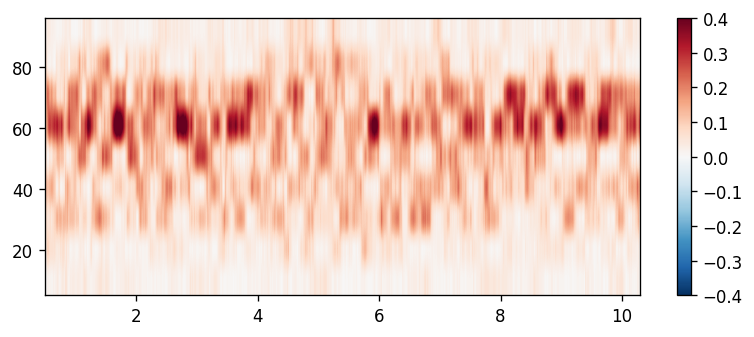

In [ ]:
plt.figure(figsize=(8, 3))
hhtools.imshow_xy(yf_mat, cmap="RdBu_r", x=tcc, y=f, vmin=-0.4, vmax=0.4)
plt.colorbar()
# plt.xlim([4, 7])

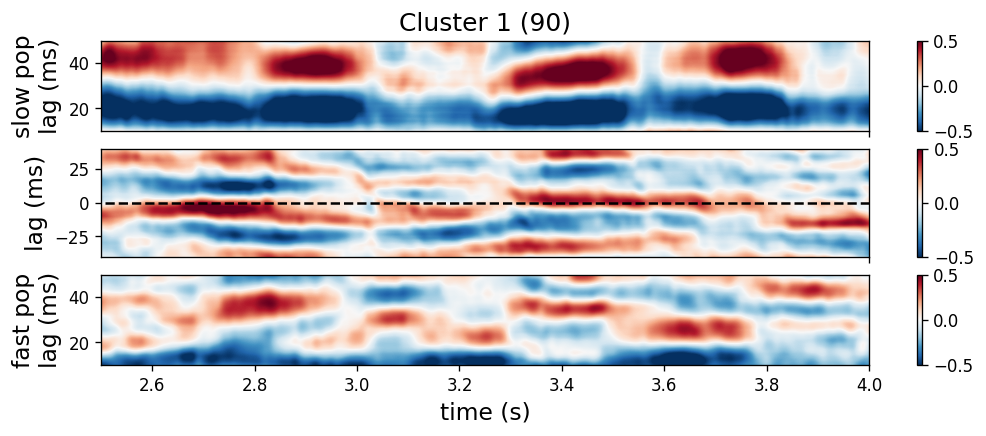

In [ ]:
def no_xlabel():
    xt, _ = plt.xticks()
    xl = plt.xlim()
    plt.xticks(xt, labels=[])
    plt.xlim(xl)
    
xl = [2.5, 4]
# xl = [1, 10]
vm = 0.5
vp = 0.5
pop_name = ["Fast", "Slow"]
    
plt.figure(figsize=(10, 3))

ax1 = plt.axes([0.1, 0.75, 0.8, 0.25])
hhtools.imshow_xy(ac_mat[1], x=tcc, y=tlag*1e3, cmap="RdBu_r", vmax=vp, vmin=-vp, interpolation="bicubic")
plt.ylabel("slow pop\nlag (ms)", fontsize=14)
no_xlabel()
plt.title("Cluster %d (%d)"%(cid, nitr), fontsize=15)
plt.colorbar()
plt.ylim([10, 50])

ax2 = plt.axes([0.1, 0.4, 0.8, 0.3])
hhtools.imshow_xy(cc_mat, x=tcc, y=tlag*1e3, cmap="RdBu_r", vmax=vm, vmin=-vm, interpolation="bicubic")
plt.plot([tcc[0], tcc[-1]], [0, 0], 'k--')
# +: slow pop / -: fast pop lead
no_xlabel()
plt.ylabel("lag (ms)", fontsize=14)
plt.colorbar()
# plt.yticks([-20, -10, 0, 10, 20])
plt.ylim([-40, 40])

ax3 = plt.axes([0.1, 0.1, 0.8, 0.25])
hhtools.imshow_xy(ac_mat[0], x=tcc, y=tlag*1e3, cmap="RdBu_r", vmax=vp, vmin=-vp, interpolation="bicubic")
plt.ylabel("fast pop\nlag (ms)", fontsize=14)

plt.xlabel("time (s)", fontsize=14)
plt.colorbar()
plt.ylim([10, 50])

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(xl)
    
# xt, _ = pl.

# Joint probability map

In [ ]:
def compute_joint_prob(func_joint, detail_data, xedges=None, yedges=None, nsample=100, teq=0.5, wbin_t=0.5, fs=2000, **kw_joint_args):
    """
    func_joint: have args as vlfp1 and vlfp2
    """
    
    nx = len(xedges)-1
    ny = len(yedges)-1
    
    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    
    def is_out(x, xl):
        if (x < xl[0]) or (x >= xl[1]):
            return True
        return False
    
    out_points = []
    joint_map = np.zeros([ny, nx])
    for _ in range(nsample):
        
        t0 = np.random.rand() * (tmax - teq - wbin_t) + teq
        
        n0 = int(t0 * fs)
        vsub = [v[n0:n0+wbin] for v in detail_data["vlfp"][1:]]
        x_set, y_set = func_joint(vsub[0], vsub[1], **kw_joint_args)
        
        if not isinstance(x_set, list) and not isinstance(x_set, np.ndarray):
            x_set, y_set = [x_set], [y_set]
            
        for x, y in zip(x_set, y_set):
            idx = int((x - xedges[0]) / dx)
            idy = int((y - yedges[0]) / dy)
        
            if is_out(idx, [0, nx]) or is_out(idy, [0, ny]):
                out_points.append([x, y])
            else:
                joint_map[idy, idx] += 1
            
    get_mid = lambda xe: (xe[1:] + xe[:-1])/2
            
    return joint_map/nsample, get_mid(xedges), get_mid(yedges), out_points

## Test peak detection algorithm

In [ ]:
def compute_cc_rand(detail_data, teq=0.5, wbin_t=1, fs=2000, max_lag=0.05):
    tmax = detail_data["ts"][-1]
    t0 = np.random.rand() * (tmax - teq - wbin_t) + teq
    n0 = int(t0 * fs)
    vsub = [v[n0:n0+int(wbin_t*fs)] for v in detail_data["vlfp"][1:]]
    cc, tlag = hhsignal.get_correlation(vsub[0], vsub[1], srate=2000, max_lag=max_lag)
    return cc, tlag*1e3, vsub 


def norm_joint(joint_map):
    norm = np.sum(joint_map, axis=0)
    norm[norm == 0] = 1e-9
    joint_map_norm = joint_map / norm.reshape(1, -1)
    return joint_map_norm

## Joint prob of autocorrelation

In [ ]:
def joint_ac_all(v1, v2, max_lag=0.05, prominence=0.05, mode=0):
    v = v1 if mode == 0 else v2
    ac, tlag = hhsignal.get_correlation(v, v, srate=2000, max_lag=max_lag)
    # plt.plot(tlag, ac)
    # plt.show()
    tlag *= 1000
    npeaks = hhsignal.detect_peak(ac, prominence=prominence, mode=0)
    npeaks = np.delete(npeaks, 0)

    return ac[npeaks], tlag[npeaks]

In [ ]:
from tqdm.notebook import trange
np.random.seed(1000)

dt = 1000/fs
tlag_bins = np.arange(dt/2, 50-dt/2+1e-3, dt)
# invt_bins = np.arange(10, 90, 2.5)
ac_bins = np.linspace(-0.1, 1, 31)

joint_map = 0
out_points = []

cid = 1
for nitr in trange(200):
    detail = sobj.load_detail(cid-1, nitr)
    joint_map_tmp, x, y, out_points_tmp = compute_joint_prob(joint_ac_all, detail,
                                                             xedges=ac_bins, yedges=tlag_bins, nsample=100,
                                                             teq=0.5, wbin_t=0.2, fs=2000, prominence=0.05, max_lag=0.05, mode=0)
    joint_map += joint_map_tmp/200
    out_points.extend(out_points_tmp)
    
    # normalization을 어디 기준으로 할 지 (row / col) 다시 생각
    
print(len(out_points) / 200 / 100 * 100)

  0%|          | 0/200 [00:00<?, ?it/s]

155.74


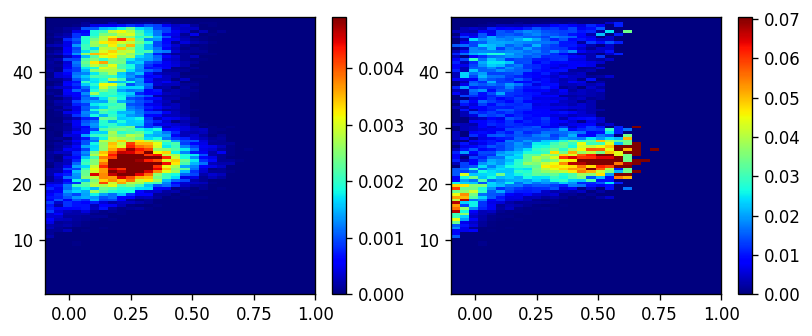

In [ ]:
plt.figure(dpi=120, figsize=(8, 3))

plt.subplot(121)
hhtools.imshow_xy(joint_map, x=x, y=y, cmap="jet", vmax=None, vmin=0, interpolation="nearest")
plt.colorbar()

plt.subplot(122)
joint_map_norm = norm_joint(joint_map)
hhtools.imshow_xy(joint_map_norm, x=x, y=y, cmap="jet", interpolation="nearest")
plt.colorbar()

plt.show()

In [ ]:
tmax = 10500
dt = 0.01
fs = 2

detail = sobj.load_detail(0, 50)

pop_rate = np.zeros([2, int(tmax*fs)])
for n in range(2000):
    nt = (np.array(detail["step_spk"][n]) * dt * fs).astype(int)
    pop_rate[n//1000, nt] += 1
    
pop_rate *= fs

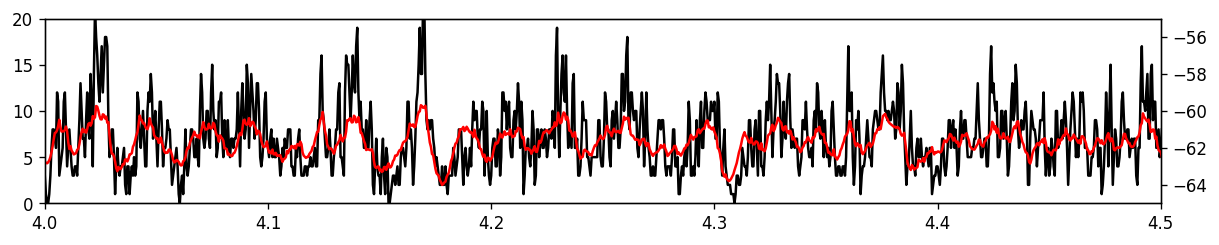

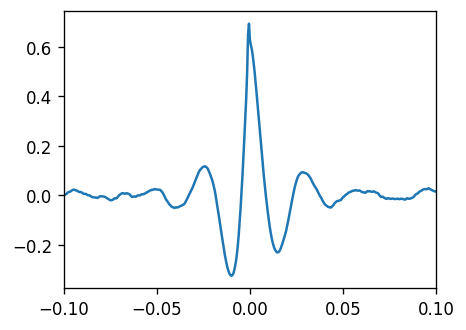

In [ ]:
nt = 0

plt.figure(dpi=120, figsize=(12, 2))

yhat = savgol_filter(pop_rate[nt], 2, 1)
plt.plot(detail["ts"], yhat, c='k')
plt.ylim([0, 20])
plt.xlim([4, 4.5])

plt.twinx()
plt.plot(detail["ts"], detail["vlfp"][nt+1], c='r')
plt.ylim([-65, -55])

plt.show()

ac, tlag = hhsignal.get_correlation(yhat, detail["vlfp"][nt+1], 2000)

plt.figure()
plt.plot(tlag, ac)
plt.xlim([-0.1, 0.1])
plt.show()

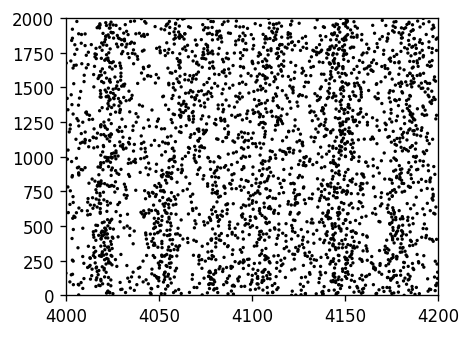

In [ ]:
hhtools.draw_spk(detail["step_spk"], dt=0.01, xl=(4000, 4200))


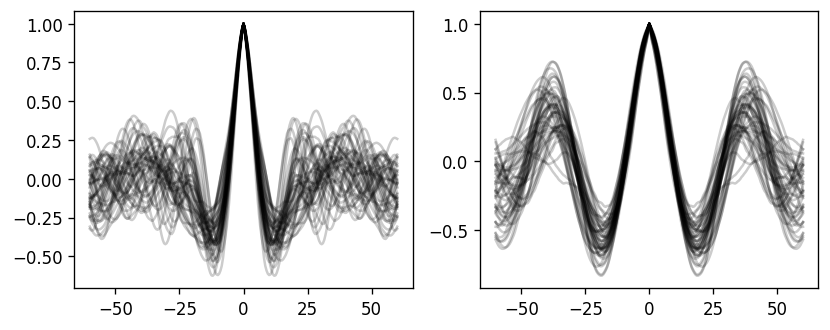

In [ ]:
# Test

cid = 3
detail_data = sobj.load_detail(cid-1, 10)

plt.figure(figsize=(8, 3))
axs = [plt.subplot(121), plt.subplot(122)]

for _ in range(50):

    t0 = np.random.rand() * (tmax - teq - wbin_t) + teq
    n0 = int(t0 * fs)
    vsub = [v[n0:n0+int(wbin_t*fs)] for v in detail_data["vlfp"]]

    for nt in range(2):
        ac, tlag = hhsignal.get_correlation(vsub[nt+1], vsub[nt+1], srate=2000, max_lag=0.06)
        axs[nt].plot(tlag*1e3, ac, 'k', alpha=0.2)

plt.show()


## Cross-correlation peak

In [ ]:
def joint_cc_all(v1, v2, max_lag=0.05, prominence=0.05):
    cc, tlag = hhsignal.get_correlation(v1, v2, srate=2000, max_lag=max_lag)
    tlag *= 1000
    npeaks = hhsignal.detect_peak(cc, prominence=prominence, mode=0)
    return cc[npeaks], tlag[npeaks]

In [ ]:
from tqdm.notebook import trange

tmax = 10.5
wbin_t = 0.2
wbin = int(wbin_t * fs)
max_lag = 0.05 # ms

np.random.seed(1000)

dt = 2000/fs
tlag_bins = np.arange(-50+dt/2, 50-dt/2+1e-3, dt)
cc_bins = np.linspace(-0.1, 1, 31)

out_points_cc = []
joint_map_cc = []
for cid in trange(1,9):
    joint_map = 0
    out_points_cc.append([])
    for nitr in range(200):
        detail = sobj.load_detail(cid-1, nitr)
        joint_map_tmp, x, y, out_points_tmp = compute_joint_prob(joint_cc_all, detail,
                                                                xedges=cc_bins, yedges=tlag_bins, nsample=100,
                                                                teq=0.5, wbin_t=0.2, fs=2000, prominence=0.01, max_lag=max_lag)
        joint_map += joint_map_tmp/200
        out_points_cc[-1].extend(out_points_tmp)
    joint_map_cc.append(joint_map)
    
# print(len(out_points) / 200 / 100 * 100)

  0%|          | 0/8 [00:00<?, ?it/s]

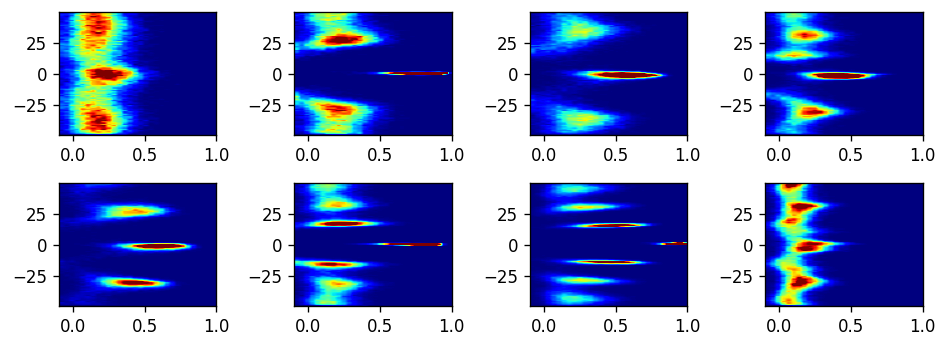

In [ ]:
plt.figure(figsize=(8, 3))
for n in range(8):
    plt.subplot(2,4,n+1)
    hhtools.imshow_xy(joint_map_cc[n], x=x, y=y, cmap="jet", vmax=None)
    
plt.tight_layout()
plt.show()

## Cross-correlation peaks (max)

In [ ]:
def joint_cc_max(v1, v2, max_lag=0.05, prominence=0.05):
    cc, tlag = hhsignal.get_correlation(v1, v2, srate=2000, max_lag=max_lag)
    tlag *= 1000
    npeaks = hhsignal.detect_peak(cc, prominence=prominence, mode=0)
    
    nmax = npeaks[np.argmax(cc[npeaks])]
    return cc[nmax], tlag[nmax]

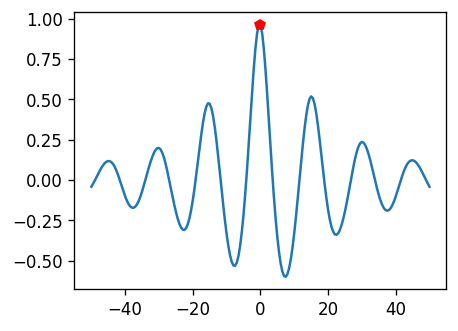

In [ ]:
cid = 7

detail_data = sobj.load_detail(cid-1, 10)

cc, tlag, vsub = compute_cc_rand(detail_data)
# npeaks = hhsignal.detect_peak(cc, prominence=0.01, mode=0)
cc_peak, t_peak = joint_cc_max(vsub[0], vsub[1])

plt.figure()
plt.plot(tlag, cc)
plt.plot(t_peak, cc_peak, 'rp')

# for n in npeaks:
    # plt.plot(tlag[n], cc[n], 'rp')

In [ ]:
tmax = 10.5
wbin_t = 0.2
wbin = int(wbin_t * fs)
max_lag = 0.05 # ms

np.random.seed(1000)

dt = 2000/fs
tlag_bins = np.arange(-50-dt/2, 50+dt/2+1e-3, dt)
cc_bins = np.linspace(-0.1, 1, 31)

out_points_cc = []
joint_map_cc = []
for cid in trange(1,9):
    joint_map = 0
    out_points_cc.append([])
    for nitr in range(200):
        detail = sobj.load_detail(cid-1, nitr)
        joint_map_tmp, x, y, out_points_tmp = compute_joint_prob(joint_cc_max, detail,
                                                                xedges=cc_bins, yedges=tlag_bins, nsample=100,
                                                                teq=0.5, wbin_t=0.2, fs=2000, prominence=0.01, max_lag=max_lag)
        joint_map += joint_map_tmp/200
        out_points_cc[-1].extend(out_points_tmp)
    joint_map_cc.append(joint_map)
    
# print(len(out_points) / 200 / 100 * 100)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
def logmap(im):
    im_tmp = im.copy()
    id_zero = im_tmp == 0
    im_tmp[id_zero] = np.nan
    im_min = np.nanmin(im_tmp)

    log_im = np.log10(im_tmp)
    log_im[id_zero] = np.log10(im_min)
    
    return log_im

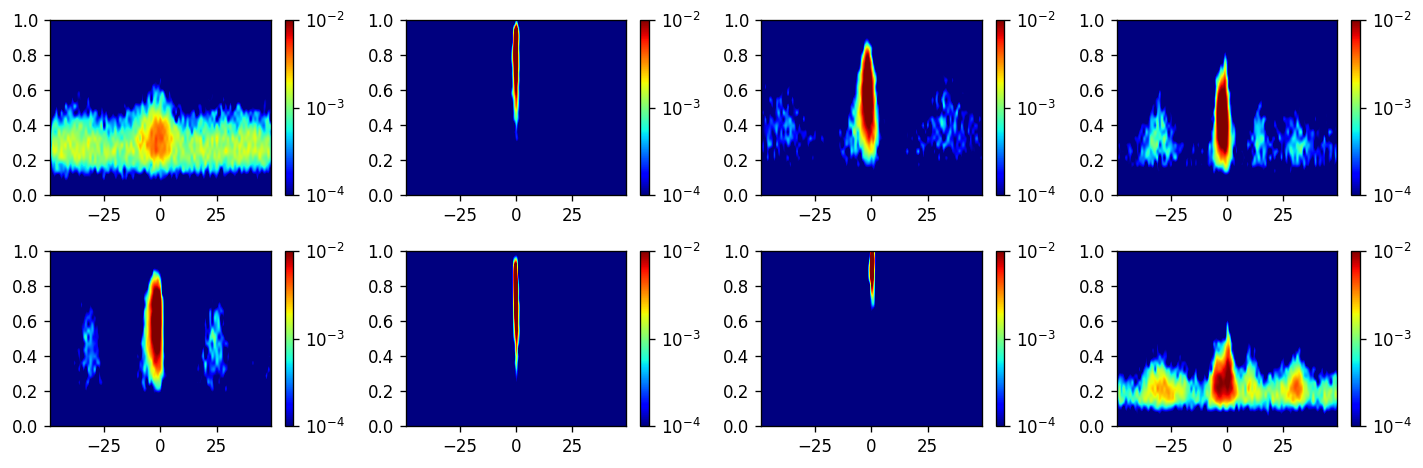

In [ ]:
plt.figure(dpi=120, figsize=(12, 4))
for n in range(8):
    plt.subplot(2,4,n+1)
    
    imlog = logmap(joint_map_cc[n])
    
    hhtools.imshow_xy(imlog.T, x=y, y=x, cmap="jet", vmax=-2., vmin=-4, interpolation="spline16")
    plt.xlim([-49, 49])
    plt.ylim([0, 1])
    
    cbar = plt.colorbar(ticks=[-4, -3, -2])
    cbar.ax.set_yticklabels([r"$10^{%d}$"%(n) for n in [-4, -3, -2]])
    
plt.tight_layout()
plt.show()

## CC - AC_F

In [ ]:
def joint_cc_ac_max(v1, v2, max_lag=0.05, prominence=0.05):
    cc, tlag = hhsignal.get_correlation(v1, v2, srate=2000, max_lag=max_lag)
    tlag *= 1000
    npeaks = hhsignal.detect_peak(cc, prominence=prominence, mode=0)
    nmax = npeaks[np.argmax(cc[npeaks])]
    # cmax = cc[nmax]
    tmax = tlag[nmax]
    
    try:
        ac, tlag = hhsignal.get_correlation(v1, v1, srate=2000, max_lag=max_lag)
        tlag *= 1000
        npeaks = hhsignal.detect_peak(ac, prominence=prominence, mode=0)
        amax = ac[npeaks[1]]
    except:
        amax = -1
    
    return tmax, amax

In [ ]:
from tqdm.notebook import trange

wbin = int(wbin_t * fs)
max_lag = 0.05 # ms

np.random.seed(1000)

dt = 1000/fs
tlag_bins = np.arange(-5+dt/2, 5-dt/2+1e-3, dt)
ac_bins = np.linspace(-0.1, 1, 31)
cc_bins = np.linspace(-0.1, 1, 31)

joint_map = 0
out_points = []

cid = 2
for nitr in trange(200):
    detail = sobj.load_detail(cid-1, nitr)
    joint_map_tmp, x, y, out_points_tmp = compute_joint_prob(joint_cc_ac_max, detail,
                                                             xedges=tlag_bins, yedges=ac_bins, nsample=100,
                                                             teq=0.5, wbin_t=0.2, fs=2000, prominence=0.01, max_lag=max_lag)
    joint_map += joint_map_tmp/200
    out_points.extend(out_points_tmp)
    
print(len(out_points) / 200 / 100 * 100)

  0%|          | 0/200 [00:00<?, ?it/s]

52.405


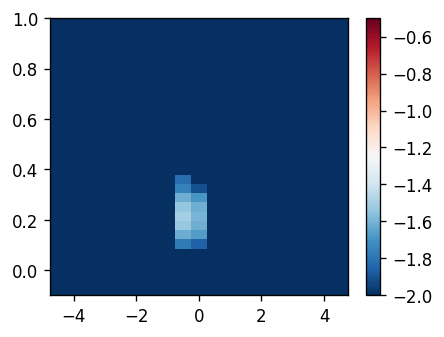

In [ ]:
plt.figure()
hhtools.imshow_xy(logmap(joint_map), x=x, y=y, vmax=-0.5, vmin=-2, cmap="RdBu_r")
plt.colorbar()

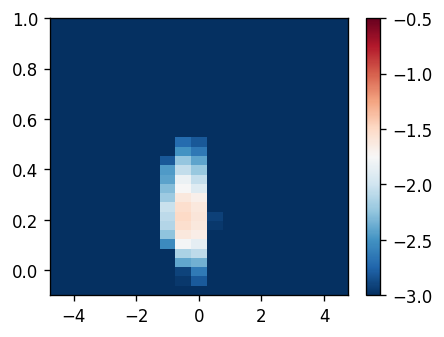

In [ ]:
plt.figure()
hhtools.imshow_xy(logmap(joint_map), x=x, y=y, vmax=-0.5, vmin=-3, cmap="RdBu_r")
plt.colorbar()

## Detect all peaks

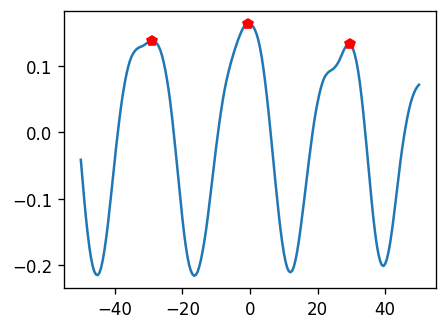

In [ ]:
cid = 8

detail_data = sobj.load_detail(cid-1, 10)

cc, tlag, vsub = compute_cc_rand(detail_data)
# npeaks = hhsignal.detect_peak(cc, prominence=0.01, mode=0)
cc_peak, t_peak = joint_cc_all(vsub[0], vsub[1])

plt.figure()
plt.plot(tlag, cc)

for t, c in zip(t_peak, cc_peak):
    plt.plot(t, c, 'rp')

# for n in npeaks:
    # plt.plot(tlag[n], cc[n], 'rp')

In [ ]:
from tqdm.notebook import trange

wbin = int(wbin_t * fs)
max_lag = 0.05 # ms

np.random.seed(1000)

dt = 2000/fs
tlag_bins = np.arange(-50+dt/2, 50-dt/2+1e-3, dt)
cc_bins = np.linspace(-0.1, 1, 31)

joint_map = 0
out_points = []

cid = 8

for nitr in trange(200):
    detail = sobj.load_detail(cid-1, nitr)
    joint_map_tmp, x, y, out_points_tmp = compute_joint_prob(joint_cc_all, detail,
                                                             xedges=cc_bins, yedges=tlag_bins, nsample=100,
                                                             teq=0.5, wbin_t=0.2, fs=2000, prominence=0.01, max_lag=max_lag)
    joint_map += joint_map_tmp/200
    out_points.extend(out_points_tmp)
    
    
    
print(len(out_points) / 200 / 100 * 100)

  0%|          | 0/200 [00:00<?, ?it/s]

0.8100000000000002


In [ ]:
def norm_joint(joint_map):
    # normalization을 어디 기준으로 할 지 (row / col) 다시 생각
    norm = np.sum(joint_map, axis=1)
    norm[norm == 0] = 1e-9
    joint_map_norm = joint_map / norm.reshape(-1, 1)
    return joint_map_norm

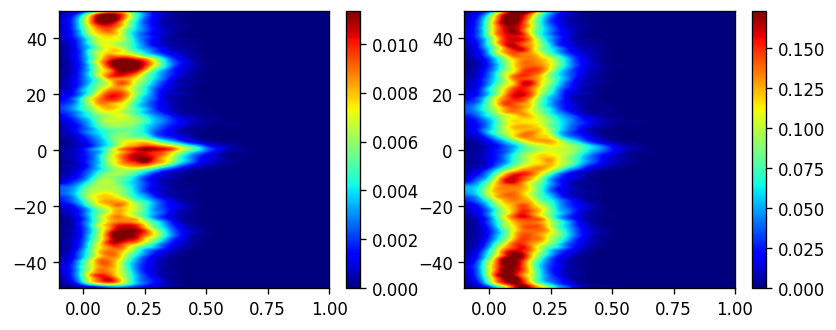

In [ ]:
plt.figure(dpi=120, figsize=(8, 3))

plt.subplot(121)
hhtools.imshow_xy(joint_map, x=x, y=y, cmap="jet", vmax=None, vmin=0, interpolation="bicubic")
plt.colorbar()

plt.subplot(122)
joint_map_norm = norm_joint(joint_map)
hhtools.imshow_xy(joint_map_norm, x=x, y=y, cmap="jet", interpolation="bicubic")
plt.colorbar()

plt.show()

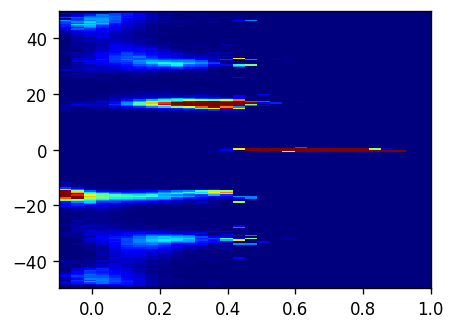

In [ ]:
joint_map_norm = norm_joint(joint_map)

plt.figure()
hhtools.imshow_xy(joint_map_norm, x=x, y=y, cmap="jet", vmax=None, vmin=0, interpolation="None")
plt.show()

In [ ]:
joint_map_norm = norm_joint(joint_map)

plt.figure()
hhtools.imshow_xy(logmap(joint_map_norm), x=x, y=y, cmap="jet", interpolation="None")
plt.show()

NameError: name 'logmap' is not defined

<Figure size 480x360 with 0 Axes>

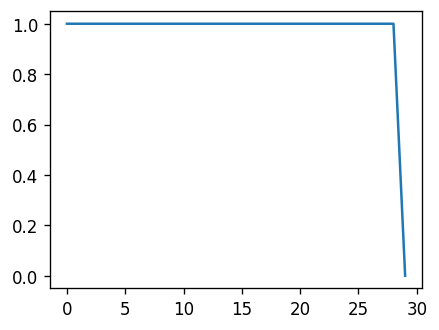

In [ ]:
plt.plot(np.sum(joint_map_norm, axis=0))

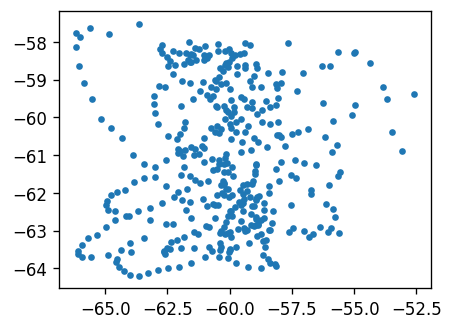

In [ ]:
plt.plot(vsub[0], vsub[1], '.')

In [ ]:
c, t = joint_cc_all(vsub[0], vsub[1])
print(t, c)

xedges = tlag_bins
yedges = cc_bins

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]

def is_out(x, xl):
    if (x < xl[0]) or (x >= xl[1]):
        return True
    return False

idx = int((t - xedges[0]) / dx)
idy = int((c - yedges[0]) / dy)

print(idx, idy)

print(is_out(idx, [0, len(xedges)-1]))
print(is_out(idy, [0, len(yedges)-1]))

array([154,  94,  56,  29])

## CC1-tlag

In [ ]:
def joint_cc1_t1(v1, v2, max_lag=0.05, prominence=0.05):
    """ Find the CC peak based on the distance from 0 """
    cc, tlag = hhsignal.get_correlation(v1, v2, srate=2000, max_lag=max_lag)
    tlag *= 1000
    npeaks = hhsignal.detect_peak(cc, prominence=prominence, mode=0)
    nzero = len(tlag)//2
    id_zero = npeaks[np.argmin(np.abs((npeaks - nzero)))]
    
    return cc[id_zero], tlag[id_zero]

In [ ]:
c, t = joint_cc1_t1(vsub[0], vsub[1])
print(t, c)

xedges = tlag_bins
yedges = cc_bins

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]

def is_out(x, xl):
    if (x < xl[0]) or (x >= xl[1]):
        return True
    return False

idx = int((t - xedges[0]) / dx)
idy = int((c - yedges[0]) / dy)

print(idx, idy)

print(is_out(idx, [0, len(xedges)-1]))
print(is_out(idy, [0, len(yedges)-1]))

-5.999999999999964 0.12774241710210413
6 3
False
False


  0%|          | 0/200 [00:00<?, ?it/s]

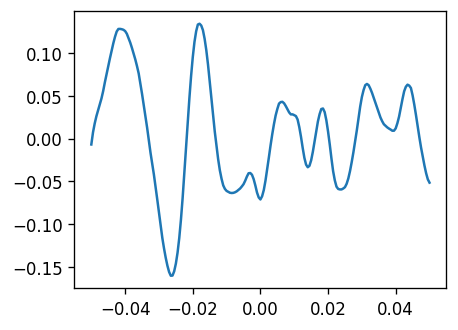

-1 10 30 30 -0.04034612397319608 -2.9999999999995586 [0.0, 1.0] [-10.0, 10.0]


ValueError: Out

In [ ]:
from tqdm.notebook import trange

wbin = int(wbin_t * fs)
max_lag = 0.05 # ms

np.random.seed(1000)
tlag_bins = np.linspace(-10, 10, 31)
cc_bins = np.linspace(0, 1, 31)

joint_map = 0
out_points = []

cid = 8

for nitr in trange(200):
    detail = sobj.load_detail(cid-1, nitr)
    joint_map_tmp, x, y, out_points_tmp = compute_joint_prob(joint_cc1_t1, detail,
                                                        xedges=cc_bins, yedges=tlag_bins, nsample=100,
                                                        teq=0.5, wbin_t=0.2, fs=2000, prominence=0.01, max_lag=0.5)
    joint_map += joint_map_tmp/200
    out_points.extend(out_points_tmp)
    
    # normalization을 어디 기준으로 할 지 (row / col) 다시 생각
    
print(len(out_points) / 200 / 100 * 100)

In [ ]:
out_points[4]

[-0.07574251190222425, 6.000000000000449]

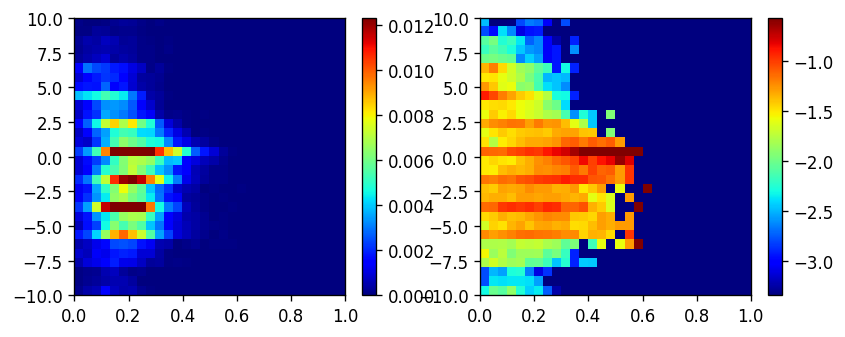

In [ ]:
def logmap(im):
    im_copy = im.copy()
    
    is_zero = im_copy == 0
    im_copy[is_zero] = 1
    im_copy[is_zero] = np.min(im_copy)
    
    return np.log10(im_copy)


def norm_joint(joint_map):
    norm = np.sum(joint_map, axis=0)
    norm[norm == 0] = 1e-9
    joint_map_norm = joint_map / norm.reshape(1, -1)
    return joint_map_norm


plt.figure(dpi=120, figsize=(8, 3))

plt.subplot(121)
hhtools.imshow_xy(joint_map, x=x, y=y, cmap="jet", vmax=None, vmin=0, interpolation="None")
plt.colorbar()

plt.subplot(122)
joint_map_norm = norm_joint(joint_map)
hhtools.imshow_xy(logmap(joint_map_norm), x=x, y=y, cmap="jet", interpolation="nearest")
plt.colorbar()

plt.show()

# plt.colorbar()

In [ ]:
norm = np.sum(joint_map, axis=0)
norm[norm == 0] = 1e-9
joint_map_norm = joint_map / norm.reshape(1, -1)

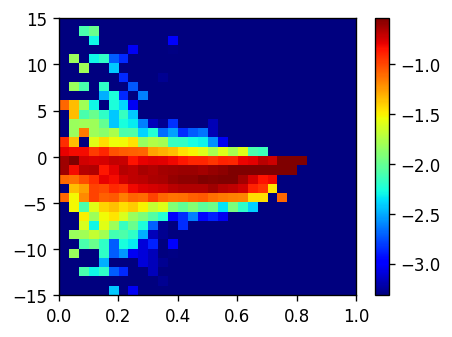

In [ ]:


hhtools.imshow_xy(logmap(joint_map_norm), x=x, y=y, cmap="jet", interpolation="nearest")
plt.colorbar()

In [ ]:
norm = np.sum(joint_map, axis=0)

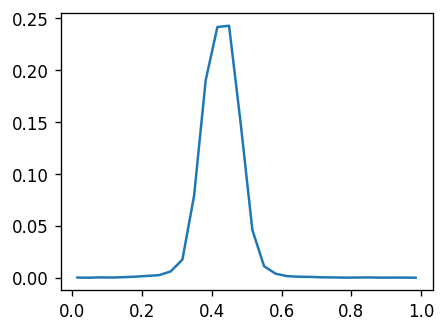

In [ ]:
plt.plot(x, np.sum(joint_map, axis=1))

In [ ]:
joint_map.shape

(30, 30)

## CC2p - tlag

In [ ]:
def joint_cc2_t2(v1, v2, max_lag=0.05, prominence=0.05, positive=True):
    """ Find the CC peak based on the distance from 0 """
    cc, tlag = hhsignal.get_correlation(v1, v2, srate=2000, max_lag=max_lag)
    tlag *= 1000
    npeaks = hhsignal.detect_peak(cc, prominence=prominence, mode=0)
    nzero = len(tlag)//2
    # id_zero = npeaks[np.argmin(np.abs((npeaks - nzero)))]
    
    # find the largest positive peak
    # remove the closest peak
    npeaks = np.delete(npeaks, np.argmin(np.abs((npeaks - nzero))))
    
    if positive:
        npeaks_sgn = npeaks[tlag[npeaks] > 0]
    else:
        npeaks_sgn = npeaks[tlag[npeaks] < 0]
    
    nmax = npeaks_sgn[np.argmax(cc[npeaks_sgn])]
    
    return cc[nmax], tlag[nmax]

In [ ]:
from tqdm.notebook import trange

wbin = int(wbin_t * fs)
max_lag = 0.05 # ms

np.random.seed(1000)
tlag_bins = np.linspace(0, 50, 31)
cc_bins = np.linspace(0, 1, 31)

joint_map_cc2p = 0
out_points_cc2p = []

cid = 6

for nitr in trange(200):
    detail = sobj.load_detail(cid-1, nitr)
    joint_map_tmp, xp, yp, out_points_tmp = compute_joint_prob(joint_cc2_t2, detail,
                                                        xedges=cc_bins, yedges=tlag_bins, nsample=100,
                                                        teq=0.5, wbin_t=0.2, fs=2000,
                                                        prominence=0.01, max_lag=0.5, positive=True)
    joint_map_cc2p += joint_map_tmp/200
    out_points_cc2p.extend(out_points_tmp)
    
    # normalization을 어디 기준으로 할 지 (row / col) 다시 생각

  0%|          | 0/200 [00:00<?, ?it/s]

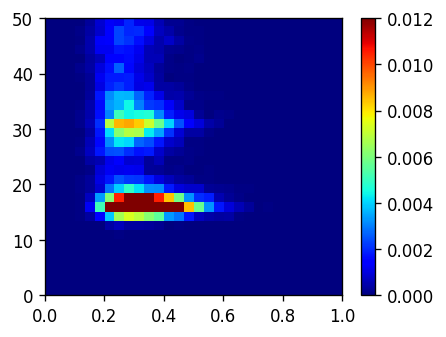

In [ ]:
hhtools.imshow_xy(joint_map_cc2p, x=xp, y=yp, cmap="jet", vmax=0.012, vmin=0, interpolation="nearest")
plt.colorbar()
plt.show()

In [ ]:
from tqdm.notebook import trange

wbin = int(wbin_t * fs)
max_lag = 0.05 # ms

np.random.seed(1000)
tlag_bins = np.linspace(-50, 0, 31)
cc_bins = np.linspace(0, 1, 31)

joint_map_cc2n = 0
out_points_cc2n = []

cid = 6

for nitr in trange(200):
    detail = sobj.load_detail(cid-1, nitr)
    joint_map_tmp, xn, yn, out_points_tmp = compute_joint_prob(joint_cc2_t2, detail,
                                                        xedges=cc_bins, yedges=tlag_bins, nsample=100,
                                                        teq=0.5, wbin_t=0.2, fs=2000,
                                                        prominence=0.01, max_lag=0.1, positive=False)
    joint_map_cc2n += joint_map_tmp/200
    out_points_cc2n.extend(out_points_tmp)
    
    # normalization을 어디 기준으로 할 지 (row / col) 다시 생각

  0%|          | 0/200 [00:00<?, ?it/s]

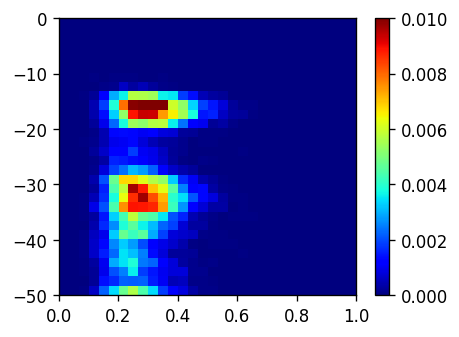

In [ ]:
hhtools.imshow_xy(joint_map_cc2n, x=xn, y=yn, cmap="jet", vmax=0.01, vmin=0, interpolation="nearest")
plt.colorbar()

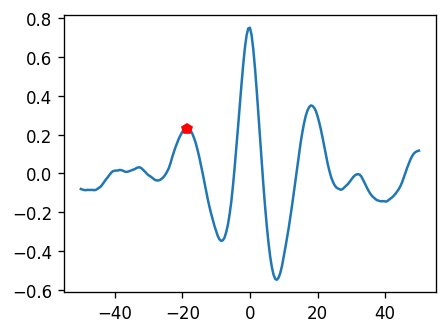

In [ ]:
cid = 6

detail_data = sobj.load_detail(cid-1, 10)

t0 = np.random.rand() * (tmax - teq - wbin_t) + teq
n0 = int(t0 * fs)
vsub = [v[n0:n0+wbin] for v in detail_data["vlfp"][1:]]

cc, tlag = hhsignal.get_correlation(vsub[0], vsub[1], srate=2000, max_lag=0.05)
tlag *= 1000

c, t = joint_cc2_t2(vsub[0], vsub[1], positive=False)

plt.figure()
plt.plot(tlag, cc)
plt.plot(t, c, 'rp')
plt.show()

In [ ]:
detail.keys()

dict_keys(['step_spk', 'vlfp', 'ts', 'nid', 'info'])

In [ ]:
def compute_pop_rate(step_spk, tmax, fs=2000, dt=0.01):
    # time (ms)
    nmax = int(tmax / 1000 * fs)
    pop_rate = np.zeros(nmax)
    
    for nstep in step_spk:
        ind = (np.array(nstep) * dt / 1000 * fs).astype(int)
        pop_rate[ind] += 1
    
    return pop_rate / len(step_spk) * fs
    


In [ ]:
detail = sobj.load_detail(4, 100)

pop_rate = compute_pop_rate(detail["step_spk"], 10500)
# print(pop_rate.shape, len(detail["ts"]))


(21000,) 21000


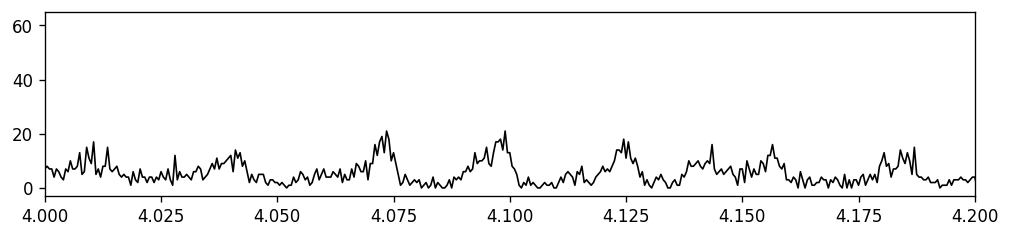

In [ ]:
plt.figure(dpi=120, figsize=(10, 2))
plt.plot(detail["ts"], pop_rate, c='k', lw=1)
plt.xlim([4, 4.2])
plt.show()

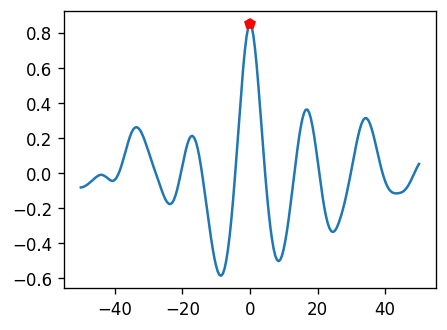

In [ ]:
cid = 6

detail_data = sobj.load_detail(cid-1, 10)

t0 = np.random.rand() * (tmax - teq - wbin_t) + teq
n0 = int(t0 * fs)
vsub = [v[n0:n0+wbin] for v in detail_data["vlfp"][1:]]

cc, tlag = hhsignal.get_correlation(vsub[0], vsub[1], srate=2000, max_lag=0.05)
tlag *= 1000

c, t = joint_cc1_t1(vsub[0], vsub[1], max_lag=0.05)

plt.figure()
plt.plot(tlag, cc)
plt.plot(t, c, 'rp')
plt.show()

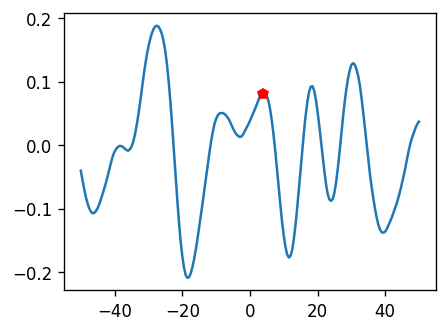

In [ ]:
cid = 8

detail_data = sobj.load_detail(cid-1, 10)

t0 = np.random.rand() * (tmax - teq - wbin_t) + teq
n0 = int(t0 * fs)
vsub = [v[n0:n0+wbin] for v in detail_data["vlfp"][1:]]

cc, tlag = hhsignal.get_correlation(vsub[0], vsub[1], srate=2000, max_lag=0.05)
tlag *= 1000

c, t = joint_cc1_t1(vsub[0], vsub[1], max_lag=0.05)

plt.figure()
plt.plot(tlag, cc)
plt.plot(t, c, 'rp')
plt.show()

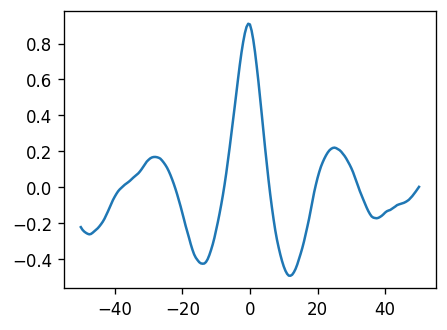

In [ ]:
plt.plot(tlag, cc)

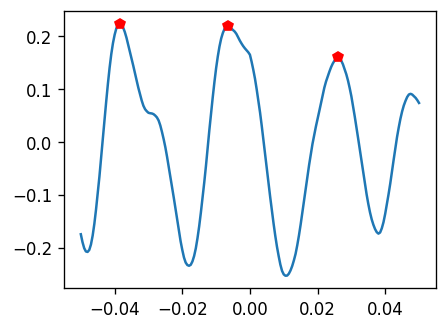

In [ ]:
cc, tlag = hhsignal.get_correlation(vsub[0], vsub[1], srate=2000, max_lag=0.05)
npeaks = hhsignal.detect_peak(cc, prominence=0.05, mode=0)

plt.figure()
plt.plot(tlag, cc)
plt.plot(tlag[npeaks], cc[npeaks], 'rp')

In [ ]:
npeaks.index(87)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
f(1)

2

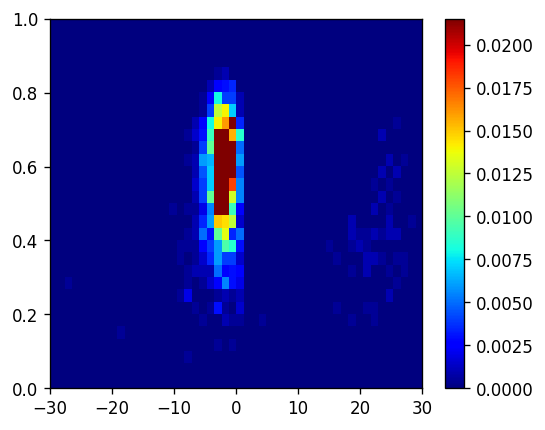

In [ ]:
x = (tlag_bins[1:] + tlag_bins[:-1])/2
y = (cc_bins[1:] + cc_bins[:-1])/2

plt.figure(figsize=(5, 4))
hhtools.imshow_xy(cc1_joint_prob, x=x, y=y, cmap="jet")
plt.colorbar()
plt.show()

In [ ]:
vsub[0].shape

(2000,)

In [ ]:
0.2 * 2000

400.0

In [ ]:
len(cc)

401

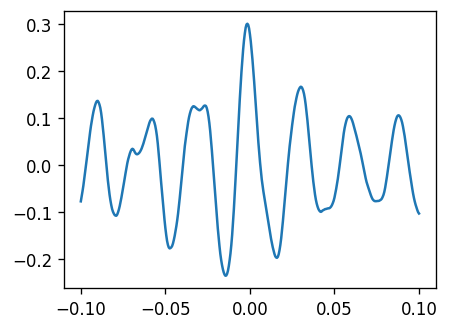

In [ ]:
plt.plot(tlag, cc)

In [ ]:
p

20800

In [ ]:
len(detail["ts"])

21000

In [ ]:
n0 / fs

9.4

In [ ]:
tmax

10.5

In [ ]:
mbin_t

0.1

In [ ]:
num_points

90

# Test state filter

In [ ]:
fs = int(2000)
tmax = 10.5
teq  = 0.5
wbin_t = 1

max_sample = 10

cid = 4

len_freq = 51
len_amp  = 21

fedges = np.linspace(0, 100, len_freq)
aedges = np.linspace(0, 1,   len_amp)
fa_joint_map = np.zeros([len_freq, len_amp, 2])

df = fedges[1] - fedges[0]
da = aedges[1] - aedges[0]

for nitr in range(200):
    detail = sobj.load_detail(cid-1, nitr)
    
    for _ in range(max_sample):
    
        n0 = int((np.random.rand() * (tmax - teq - wbin_t) + teq) * fs)
        vsub = [v[n0:n0+int(wbin_t*fs)] for v in detail["vlfp"][1:]]
        
        for n in range(2):
            ac_sub, tlag = hhsignal.get_correlation(vsub[n], vsub[n], fs, max_lag=0.2)
            npeaks = hhsignal.detect_peak(ac_sub, 0.05, mode=0)
            
            # pick ID
            nid = npeaks[1]
            fp = 1/tlag[nid]
            nf = int(fp/df)
            na = int(ac_sub[nid]/da)
            
            fa_joint_map[nf, na, n] += 1
    
fa_joint_map /= 200 * max_sample

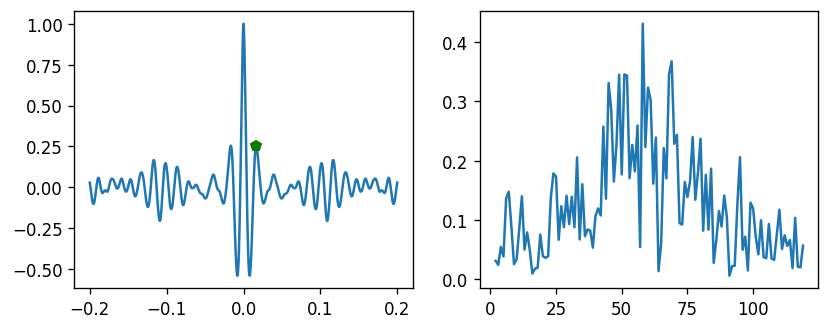

In [ ]:
# np.random.seed(100)

n0 = int((np.random.rand() * (tmax - teq - wbin_t) + teq) * fs)
vsub = [v[n0:n0+int(wbin_t*fs)] for v in detail["vlfp"][1:]]
ac_sub, tlag = hhsignal.get_correlation(vsub[0], vsub[0], fs, max_lag=0.2)

idp_1st, idp_large = hhsignal.detect_peak(ac_sub, 0.05, mode=3)

plt.figure(dpi=120, figsize=(8, 3))
plt.subplot(121)
plt.plot(tlag, ac_sub)
plt.plot(tlag[idp_1st[1]], ac_sub[idp_1st[1]], 'rp')
plt.plot(tlag[idp_large[1]], ac_sub[idp_large[1]], 'gp')

plt.subplot(122)
ypsd, f = hhsignal.get_fft(vsub[0], 2000, frange=(2, 120))
plt.plot(f, ypsd)
plt.show()

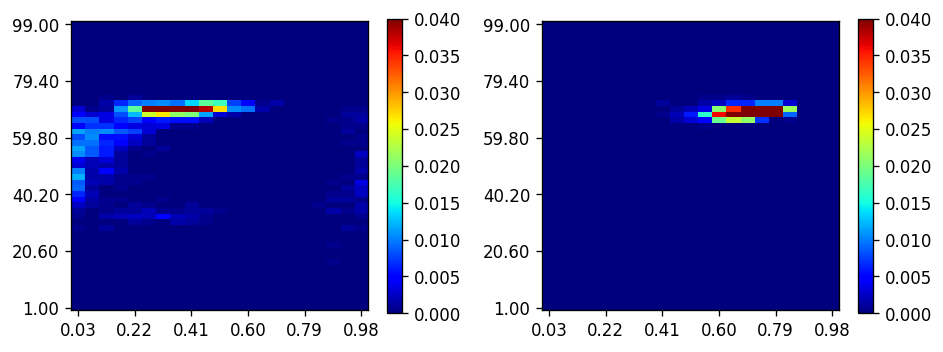

In [ ]:
def get_x(edges):
    return (edges[1:] + edges[:-1])/2

plt.figure(dpi=120, figsize=(8, 3))
for n in range(2):
    plt.subplot(1,2,n+1)
    hhtools.imshow_sq(fa_joint_map[:,:,n], x=get_x(aedges), y=get_x(fedges), interpolation="none", vmin=0, vmax=0.04)
    plt.colorbar()

plt.tight_layout()
plt.show()

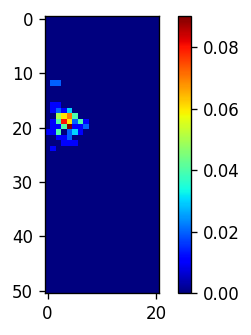

In [ ]:
plt.figure()
plt.imshow(fa_joint_map[:, :, 0], cmap="jet")
plt.colorbar()

In [ ]:
ac_sub[npeaks]

array([1.00000008, 0.34511578])

In [ ]:
cid = 1
nitr = 10

fs = int(2000)

detail = sobj.load_detail(cid-1, nitr)
idt = detail["ts"] > 0.5

vlfp = [v[idt] for v in detail["vlfp"]]
ts   = detail["ts"][idt]



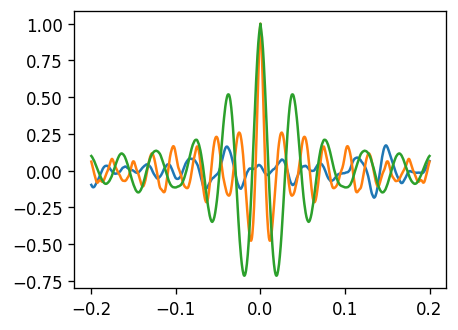

In [ ]:
tmax = detail["ts"][-1]
teq  = 0.5
wbin_t = 1

n0 = int((np.random.rand() * (tmax - teq - wbin_t) + teq) * fs)
vsub = [v[n0:n0+int(wbin_t*fs)] for v in detail["vlfp"][1:]]

cc, tlag = hhsignal.get_correlation(vsub[0], vsub[1], fs, max_lag=0.2)
ac = []
for n in range(2):
    ac_sub, _ = hhsignal.get_correlation(vsub[n], vsub[n], fs, max_lag=0.2)
    ac.append(ac_sub)
    
plt.figure(figsize=(4,3))
plt.plot(tlag, cc)
plt.plot(tlag, ac[0])
plt.plot(tlag, ac[1])
plt.show()

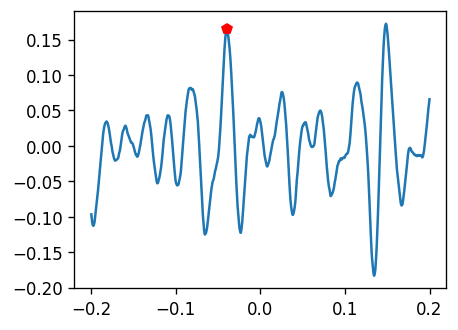

In [ ]:
idp = hhsignal.detect_peak(cc, prominence=0.1, mode=0)
    
idp3 = idp[np.argsort(np.abs(tlag[idp]))[:3]] # use first 3 points
if np.abs(idp3[0]) < 1e-5:
    idp3 = idp3[:2]

npeak = idp3[np.argmax(cc[idp3])]        
        
plt.figure()
plt.plot(tlag, cc)
for n in [npeak]:
    plt.plot(tlag[n], cc[n], 'rp')

